In [1]:
import sys
import json
import os
from datetime import datetime
import pandas as pd
import pyarrow.parquet as pq
import time
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sankey import Sankey
from scipy import stats
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# Import tableone
try:
    from tableone import TableOne, load_dataset
except (ModuleNotFoundError, ImportError):
    # install on Colab
    !pip install tableone
    from tableone import TableOne, load_dataset

In [2]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils import config
config = config.load_config()

Loaded configuration from config.json
Loaded configuration from config.json


## please change site_name, tables_path, output_path, and file_type 

In [3]:
# Access configuration parameters
site_name = config['site_name']
tables_path = config['tables_path']
file_type = config['file_type']
output_path = os.path.join("..", "output", "final")
intermediate_output_path = os.path.join("..", "output", "intermediate")

# Make sure the directory exists; if not, create it
if not os.path.exists(output_path):
    os.makedirs(output_path)
if not os.path.exists(intermediate_output_path):
    os.makedirs(intermediate_output_path)

# Print the configuration parameters
print(f"Site Name: {site_name}")
print(f"Tables Path: {tables_path}")
print(f"Output path: {output_path}")
print(f"Intermediate output path: {intermediate_output_path}")
print(f"File Type: {file_type}")

Site Name: UCMC
Tables Path: /Users/kavenchhikara/Desktop/CLIF/CLIF-UCMC/rclif/c19
Output path: ../output/final
Intermediate output path: ../output/intermediate
File Type: parquet


In [4]:
## Confirm that these are the correct paths
adt_filepath = f"{tables_path}/clif_adt.{file_type}"
hospitalization_filepath = f"{tables_path}/clif_hospitalization.{file_type}" #remove clean from filename if irrelevant
patient_filepath = f"{tables_path}/clif_patient.{file_type}"
medication_filepath = f"{tables_path}/clif_medication_admin_continuous.{file_type}"
resp_support_filepath = f"{tables_path}/clif_respiratory_support.{file_type}"

In [5]:
def read_data(filepath, filetype):
    start_time = time.time()  # Record the start time
    file_name = os.path.basename(filepath) 
    if filetype == 'csv':
        df = pd.read_csv(filepath)
    elif filetype == 'parquet':
        table = pq.read_table(filepath)
        df = table.to_pandas()
    else:
        raise ValueError("Unsupported file type. Please provide either 'csv' or 'parquet'.")
    
    end_time = time.time()  # Record the end time
    load_time = end_time - start_time  # Calculate the loading time
    
    # Calculate the size of the loaded dataset in MB
    dataset_size_mb = df.memory_usage(deep=True).sum() / (1024 * 1024)
    print(f"File name: {file_name}")
    print(f"Time taken to load the dataset: {load_time:.2f} seconds")
    print(f"Size of the loaded dataset: {dataset_size_mb:.2f} MB\n")
    
    return df

adt = read_data(adt_filepath, file_type)
hosp = read_data(hospitalization_filepath, file_type)
patient = read_data(patient_filepath,file_type)
medication = read_data(medication_filepath,file_type)
resp_support = read_data(resp_support_filepath,file_type)

File name: clif_adt.parquet
Time taken to load the dataset: 0.69 seconds
Size of the loaded dataset: 218.92 MB

File name: clif_hospitalization.parquet
Time taken to load the dataset: 0.12 seconds
Size of the loaded dataset: 296.90 MB

File name: clif_patient.parquet
Time taken to load the dataset: 0.03 seconds
Size of the loaded dataset: 81.12 MB

File name: clif_medication_admin_continuous.parquet
Time taken to load the dataset: 0.52 seconds
Size of the loaded dataset: 2566.78 MB

File name: clif_respiratory_support.parquet
Time taken to load the dataset: 0.48 seconds
Size of the loaded dataset: 2429.49 MB



In [6]:
adt["location_category"].value_counts()

location_category
ed            293618
ward          196370
procedural    131292
icu            46105
l&d            25563
other           1552
stepdown         333
Name: count, dtype: int64

Other sites should edit this code on hospital category as needed depending on how it is organized

In [7]:
adt['hospital_id'].value_counts()

hospital_id
UCMC    694833
Name: count, dtype: int64

In [8]:
adt['hospital_category'] = adt['hospital_id'].str.lower().str.split().str[0]
#adt.loc[adt['location_name'] == 'KH CVIS', 'location_category'] = 'procedural'
adt['hospital_category'].value_counts()

hospital_category
ucmc    694833
Name: count, dtype: int64

In [9]:
print("number of unique hospitalization_id:",hosp["hospitalization_id"].nunique())

number of unique hospitalization_id: 448402


In [10]:
missing_admission_dttm = hosp['admission_dttm'].isnull().sum()
print("Missing admission_dttm:", missing_admission_dttm)

Missing admission_dttm: 0


In [11]:
hosp2 = hosp[["patient_id","hospitalization_id","admission_dttm","discharge_dttm","age_at_admission"]].copy()
hosp2['admission_dttm'] = pd.to_datetime(hosp2['admission_dttm'])
hosp2['discharge_dttm'] = pd.to_datetime(hosp2['discharge_dttm'])
hosp2 = hosp2[(hosp2['admission_dttm'].dt.year >= 2020) & 
                   (hosp2['admission_dttm'].dt.year <= 2021) & 
                   (hosp2['age_at_admission'] >=18)&
                    (hosp2['age_at_admission'] <=119)&
                     (hosp2['hospitalization_id'].isin(adt[adt['location_category'].str.lower() == "icu"]['hospitalization_id'].unique()))]

df = pd.merge(hosp2[["patient_id","hospitalization_id","admission_dttm","discharge_dttm"]],
                  adt[["hospitalization_id","in_dttm","out_dttm","location_category","hospital_category"]],
             on="hospitalization_id",how="left")

print("number of unique hospitalization_id:",df["hospitalization_id"].nunique())
print("number of rows in df:",len(df))

df["location_category"] = df["location_category"].str.lower().str.strip()

number of unique hospitalization_id: 11936
number of rows in df: 46675


In [12]:
adt.head()

patient_id hospitalization_id hospital_id                   in_dttm  \
0    3130859           10000180        UCMC 2024-08-05 08:17:00+00:00   
1    3130859           10000180        UCMC 2024-08-05 15:50:00+00:00   
2    2286627           10000203        UCMC 2023-06-07 04:36:00+00:00   
3     936442           10000254        UCMC 2023-03-28 11:12:00+00:00   
4    1996631           10000266        UCMC 2023-06-13 02:41:00+00:00   

                   out_dttm location_name location_category hospital_category  
0 2024-08-05 15:50:00+00:00        ED CCD                ed              ucmc  
1 2024-08-06 13:58:00+00:00          T5NE              ward              ucmc  
2 2023-06-07 14:12:00+00:00        ED CCD                ed              ucmc  
3 2023-03-28 23:59:00+00:00    CD MAIN OR        procedural              ucmc  
4 2023-06-13 05:10:00+00:00          F3BC               l&d              ucmc

In [13]:
stepdown_hospitals = pd.DataFrame(df[df["location_category"]=="stepdown"]["hospital_category"].value_counts()).reset_index()
stepdown_hospitals.to_csv(f'{output_path}/stepdown_hospitals_{site_name}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv')
stepdown_hospitals

Empty DataFrame
Columns: [hospital_category, count]
Index: []

In [14]:
# Mapping dictionary to update the location_category
location_mapping = {
    'rehab': 'Other',
    'l&d': 'Ward',
    'psych': 'Other',
    'radiology': 'Other',
    'dialysis': 'Other',
    'hospice': 'Other',
    'stepdown':'ICU',
    "icu": "ICU",
    "er": "ER",
    "ward":"Ward",
    "procedural":"Procedural",
    "other":"Other",
    'imaging':'Other',
    'ltach':'Other',
    "ed":"ER"
}

# Apply the mapping to the 'location_category' column
df['location_category'] = df['location_category'].replace(location_mapping)
df = df[df['location_category']!= "Other"] #removing "Other from the study"
print(df["location_category"].value_counts())

hospital_cat = df[["hospitalization_id","in_dttm","out_dttm","hospital_category"]]

# Step 1: Sort by patient_id and admission_dttm
hospital_block = df[["patient_id","hospitalization_id","admission_dttm","discharge_dttm"]]
hospital_block = hospital_block.drop_duplicates()
hospital_block = hospital_block.sort_values(by=["patient_id", "admission_dttm"]).reset_index(drop=True)
hospital_block = hospital_block[["patient_id","hospitalization_id","admission_dttm","discharge_dttm"]]

# Step 2: Calculate the time difference between discharge_dttm and the next admission_dttm for the same patient
hospital_block["next_admission_dttm"] = hospital_block.groupby("patient_id")["admission_dttm"].shift(-1)
hospital_block["discharge_to_next_admission_hrs"] = (
    (hospital_block["next_admission_dttm"] - hospital_block["discharge_dttm"]).dt.total_seconds() / 3600
)

# Step 3: Create linked6hrs column
hospital_block["linked6hrs"] = hospital_block["discharge_to_next_admission_hrs"] < 6
print(hospital_block["linked6hrs"].value_counts())

# Sort values to ensure correct order
hospital_block = hospital_block.sort_values(by=["patient_id", "admission_dttm"]).reset_index(drop=True)

# Initialize `new_group` with row indices + 1
hospital_block['linked_group'] = hospital_block.index + 1

# Iteratively propagate the `new_group` values to the next row
while True:
    # Shift `new_group` up by one row
    shifted = hospital_block['linked_group'].shift(-1)

    # Update `new_group` where `linked6hrs` is True and the same `patient_id`
    mask = hospital_block['linked6hrs'] & (hospital_block['patient_id'] == hospital_block['patient_id'].shift(-1))
    hospital_block.loc[mask, 'linked_group'] = shifted[mask]

    # Break if no further changes occur
    if hospital_block['linked_group'].equals(hospital_block['linked_group'].bfill()):
        break

# Backward fill `new_group` for finalized group numbers
hospital_block['linked_group'] = hospital_block['linked_group'].bfill(downcast='int')
hospital_block = pd.merge(hospital_block,hospital_cat,how="left",on="hospitalization_id")
hospital_block = hospital_block.sort_values(by=["patient_id", "admission_dttm","in_dttm","out_dttm"]).reset_index(drop=True)
hospital_block = hospital_block.drop_duplicates()

hospital_block2 = hospital_block.groupby(['patient_id','linked_group']).agg(
    admission_dttm=pd.NamedAgg(column='admission_dttm', aggfunc='min'),
    discharge_dttm=pd.NamedAgg(column='discharge_dttm', aggfunc='max'),
    hospital_category = pd.NamedAgg(column='hospital_category', aggfunc='last'),
    list_hospitalization_id=pd.NamedAgg(column='hospitalization_id', aggfunc=lambda x: sorted(x.unique()))
).reset_index()

df = pd.merge(hospital_block[["patient_id",
                              "hospitalization_id",
                              "linked_group"]].drop_duplicates(),
         df[["hospitalization_id","location_category","in_dttm","out_dttm"]], on="hospitalization_id",how="left")

df = pd.merge(df,hospital_block2[["linked_group",
                                  "admission_dttm",
                                  "discharge_dttm",
                                  "hospital_category",
                                 "list_hospitalization_id"]],on="linked_group",how="left")
df = df.drop_duplicates(subset=["patient_id","linked_group","in_dttm","out_dttm","location_category"])
df_idlist = df[["patient_id","hospitalization_id"]].drop_duplicates()
hospitalization_ids_to_remove = df[df['hospital_category'].isin(["woodstock", "valley"])]['linked_group'].unique()
df = df[~df['linked_group'].isin(hospitalization_ids_to_remove)]
df.head()

location_category
ICU           16504
Ward          14823
ER             8036
Procedural     7287
Name: count, dtype: int64
linked6hrs
False    11932
True         4
Name: count, dtype: int64


/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_97733/1303201395.py:63: FutureWarning: The 'downcast' keyword in bfill is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  hospital_block['linked_group'] = hospital_block['linked_group'].bfill(downcast='int')


patient_id hospitalization_id  linked_group location_category  \
0    1000252           24520276             1        Procedural   
1    1000252           24520276             1               ICU   
2    1000252           24520276             1              Ward   
3    1000581           13950689             2                ER   
4    1000581           13950689             2              Ward   

                    in_dttm                  out_dttm  \
0 2020-11-23 05:34:00+00:00 2020-11-23 16:21:00+00:00   
1 2020-11-23 16:21:00+00:00 2020-11-25 21:22:00+00:00   
2 2020-11-25 21:22:00+00:00 2020-11-26 18:27:00+00:00   
3 2021-03-17 03:06:00+00:00 2021-03-17 09:30:00+00:00   
4 2021-03-17 09:30:00+00:00 2021-03-25 20:03:00+00:00   

             admission_dttm            discharge_dttm hospital_category  \
0 2020-11-23 05:34:00+00:00 2020-11-26 18:27:00+00:00              ucmc   
1 2020-11-23 05:34:00+00:00 2020-11-26 18:27:00+00:00              ucmc   
2 2020-11-23 05:34:00+00:00 2020-11-26 18:27:00+00:00              ucmc   
3 2021-03-16 18:32:00+00:00 2021-04-13 14:32:00+00:00              ucmc   
4 2021-03-16 18:32:00+00:00 2021-04-13 14:32:00+00:00              ucmc   

  list_hospitalization_id  
0              [24520276]  
1              [24520276]  
2              [24520276]  
3              [13950689]  
4              [13950689]

In [15]:
print(f'Number of encounters before linking: {df["hospitalization_id"].nunique()}')
print(f'Number of encounters after linking the transfer encounters together: {df["linked_group"].nunique()}')

Number of encounters before linking: 11936
Number of encounters after linking the transfer encounters together: 11932


In [16]:
# Step 1: Sort by linked_group and in_dttm
df = df.sort_values(by=['linked_group', 'in_dttm', 'out_dttm'])
# Apply the function to each group of linked_group
df = df.sort_values(by=['linked_group', 'in_dttm', 'out_dttm'])
#stitch together ICUs if ICU --> procedure --> ICU
df['shifted_location'] = df['location_category'].shift(1)
df['new_location'] = (df['location_category'] != df['shifted_location']).cumsum()
df = df.groupby(['linked_group','new_location']).agg(
    in_dttm=pd.NamedAgg(column='in_dttm', aggfunc='min'),
    out_dttm=pd.NamedAgg(column='out_dttm', aggfunc='max'),
    location_category=pd.NamedAgg(column='location_category', aggfunc='first'), 
    patient_id=pd.NamedAgg(column='patient_id', aggfunc='first')
).reset_index()

df.sort_values(['linked_group', 'in_dttm'], inplace=True)  # Replace 'timestamp_column' with the actual column name that orders your events chronologically.
# Use groupby and shift to get previous and next 'location_category' within each hospitalization_id
df['prev_category'] = df.groupby('linked_group')['location_category'].shift(1)
df['next_category'] = df.groupby('linked_group')['location_category'].shift(-1)
# Create a boolean mask for 'Procedural' rows sandwiched between 'ICU' rows
mask = (
    (df['location_category'] == 'Procedural') &
    (df['prev_category'] == 'ICU') &
    (df['next_category'] == 'ICU')
)
# Remove the rows where the mask is True
df = df[~mask].reset_index(drop=True)
# Drop the helper columns
df.drop(columns=['prev_category', 'next_category'], inplace=True)

print("Number of unique linked hospitalization_id:", df["linked_group"].nunique())
print("Number of rows in df:",len(df))

Number of unique linked hospitalization_id: 11932
Number of rows in df: 42703


In [17]:
def remove_short_stays(df):
    # Ensure the in_dttm and out_dttm columns are in datetime format
    df['in_dttm'] = pd.to_datetime(df['in_dttm'], errors='coerce')
    df['out_dttm'] = pd.to_datetime(df['out_dttm'], errors='coerce')

    # Directly filter rows based on the time difference without creating a new column
    mask = (df['out_dttm'] - df['in_dttm']) >= pd.Timedelta(hours=1)
    df_filtered = df[mask]
    
    return df_filtered

# Sort the DataFrame once
df = df.sort_values(by=['linked_group', 'in_dttm', 'out_dttm'])

# Remove short stays
df = remove_short_stays(df)

# Efficiently shift and calculate new locations
df['shifted_location'] = df['location_category'].shift(1)
df['new_location'] = (df['location_category'] != df['shifted_location']).cumsum()

# Group by hospitalization_id and new_location in one operation, minimize memory use
df = df.groupby(['linked_group', 'new_location'], as_index=False).agg(
    in_dttm=('in_dttm', 'min'),
    out_dttm=('out_dttm', 'max'),
    location_category=('location_category', 'first'),
    patient_id=('patient_id', 'first')
)

# Print summary
print("Number of unique linked hospitalization_id:", df["linked_group"].nunique())
print("Number of rows in df:", len(df))


Number of unique linked hospitalization_id: 11932
Number of rows in df: 39786


In [18]:
# Convert in_dttm and out_dttm columns to datetime format
df['in_dttm'] = pd.to_datetime(df['in_dttm'])
df['out_dttm'] = pd.to_datetime(df['out_dttm'])

# Sort the DataFrame
df = df.sort_values(by=['linked_group', 'in_dttm', 'out_dttm'])

# Function to mark rows as procedural if 'Procedural' is immediately before the second ICU
def mark_procedural_before_second_icu(df):
    # Find ICU rows
    df['is_icu'] = df['location_category'] == 'ICU'
    
    # Create a group-level cumulative sum to count ICU admissions
    df['icu_count'] = df.groupby(['patient_id', 'linked_group'])['is_icu'].cumsum()

    # Create a 'procedural' column that is initially False
    df['procedural'] = False

    # Identify rows where the second ICU occurs
    for hosp_id, group in df.groupby(['patient_id', 'linked_group']):
        # Find the indices of ICU rows
        icu_rows = group[group['location_category'] == 'ICU'].index

        # If there are at least two ICU admissions
        if len(icu_rows) > 1:
            second_icu_index = icu_rows[1]  # Second ICU occurrence
            
            # Check the row immediately before the second ICU
            if second_icu_index - 1 in group.index and group.loc[second_icu_index - 1, 'location_category'] == 'Procedural':
                # Mark the row as procedural
                df.loc[second_icu_index - 1, 'procedural'] = True
                
    # Propagate procedural == True to all rows in the same hospitalization_id if any row is marked as True
    df['procedural'] = df.groupby('linked_group')['procedural'].transform('max')

    # Drop helper columns
    df.drop(columns=['is_icu', 'icu_count'], inplace=True)

    return df

# Further transformations as needed
df2 = df.copy()

# Ensure dataset is aggregated correctly
df2['shifted_location'] = df2['location_category'].shift(1)
df2['new_location'] = (df2['location_category'] != df2['shifted_location']).cumsum()

df2 = df2.groupby(['linked_group', 'new_location']).agg(
    in_dttm=('in_dttm', 'min'),
    out_dttm=('out_dttm', 'max'),
    location_category=('location_category', 'first'),
    patient_id=('patient_id', 'first')
).reset_index()

# Apply the function to mark procedural rows
df2 = mark_procedural_before_second_icu(df2)

# Output the updated DataFrame
print("Number of unique linked hospitalization_id:", df2["linked_group"].nunique())
print("Number of rows in df:", len(df2))
print("Number of linked hospitalizations marked as procedural:", df2[df2["procedural"] == True]["linked_group"].nunique())
df2[['patient_id', 'linked_group', 'location_category', 'procedural']].head()

Number of unique linked hospitalization_id: 11932
Number of rows in df: 39786
Number of linked hospitalizations marked as procedural: 183


patient_id  linked_group location_category  procedural
0    1000252             1        Procedural       False
1    1000252             1               ICU       False
2    1000252             1              Ward       False
3    1000581             2                ER        True
4    1000581             2              Ward        True

In [19]:
# Convert the 'in_dttm' and 'out_dttm' columns to datetime format (vectorized)
df2['in_dttm'] = pd.to_datetime(df2['in_dttm'])
df2['out_dttm'] = pd.to_datetime(df2['out_dttm'])

# Sort the DataFrame by hospitalization_id and datetime columns
df2 = df2.sort_values(by=['linked_group', 'in_dttm', 'out_dttm'])

# Filter directly for ICU visits
icu_visits = df2[df2['location_category'] == "ICU"]

# Get the unique hospitalization_ids that had an ICU visit
icu_visit_ids = icu_visits['linked_group'].unique()

# Filter the entire DataFrame to include only rows with those hospitalization_ids
icu_df = df2[df2['linked_group'].isin(icu_visit_ids)]

# Sort the filtered DataFrame again if needed
icu_df = icu_df.sort_values(by=['linked_group', 'in_dttm', 'out_dttm'])

# Output the resulting DataFrame and summary statistics
print("Number of unique linked hospitalization_id:", icu_df["linked_group"].nunique())
print("Number of rows in df:", len(icu_df))


Number of unique linked hospitalization_id: 11928
Number of rows in df: 39778


In [20]:
def drop_deaths_during_icu(df, patient_df):
    # Merge death_dttm from patient data into icu_df, only keep relevant columns in patient_df
    df = df.merge(patient_df[['patient_id', 'death_dttm']], on='patient_id', how='left')

    # Convert 'death_dttm', 'in_dttm', and 'out_dttm' to datetime format (more efficient bulk conversion)
    df[['death_dttm', 'in_dttm', 'out_dttm']] = df[['death_dttm', 'in_dttm', 'out_dttm']].apply(pd.to_datetime, errors='coerce')

    # Filter directly for the first ICU admission per hospitalization_id
    icu_first_admission = df[df['location_category'] == 'ICU'].sort_values('in_dttm').drop_duplicates('linked_group')

    # Identify hospitalization_id where the patient died during ICU admission
    death_during_icu = icu_first_admission.loc[
        (icu_first_admission['death_dttm'].notnull()) &
        (icu_first_admission['death_dttm'] >= icu_first_admission['in_dttm']) &
        (icu_first_admission['death_dttm'] <= icu_first_admission['out_dttm']),
        'linked_group'
    ]

    # Filter out rows where the patient died during ICU admission
    df_cleaned = df[~df['linked_group'].isin(death_during_icu)]
    dropped_df = df[df['linked_group'].isin(death_during_icu)]

    return df_cleaned, dropped_df

# Sorting the icu_df by 'hospitalization_id' and 'in_dttm'
icu_df = icu_df.sort_values(by=['linked_group', 'in_dttm'])

# Apply the function
icu_df2, dropped_deaths_df = drop_deaths_during_icu(icu_df, patient)

# Output statistics
print("Number of unique linked hospitalization_id with death during ICU:", dropped_deaths_df["linked_group"].nunique())
print("Number of unique linked hospitalization_id after removing death during ICU:", icu_df2["linked_group"].nunique())
print("Number of rows in df:", len(icu_df2))


Number of unique linked hospitalization_id with death during ICU: 600
Number of unique linked hospitalization_id after removing death during ICU: 11328
Number of rows in df: 38470


In [21]:
def drop_direct_icu_discharges(df):
    # Sort the DataFrame by hospitalization_id and in_dttm if not already sorted
    df = df.sort_values(by=['linked_group', 'in_dttm'])

    # Identify the first ICU admission for each hospitalization_id
    first_icu = df[df['location_category'] == 'ICU'].groupby('linked_group').head(1)

    # Identify the last row for each hospitalization_id
    last_row = df.groupby('linked_group').tail(1)

    # Correct the logic: Check where the first ICU row is also the last row in the hospitalization
    visits_to_drop = first_icu[first_icu.index.isin(last_row.index)]['linked_group']

    # Filter out the rows for hospitalizations where patients were discharged directly from ICU
    df_cleaned = df[~df['linked_group'].isin(visits_to_drop)]
    dropped_df = df[df['linked_group'].isin(visits_to_drop)]

    # Drop helper columns (if any)
    df_cleaned.drop(columns=['is_icu'], inplace=True, errors='ignore')

    return df_cleaned, dropped_df

# Sort the input DataFrame
icu_df2 = icu_df2.sort_values(by=['linked_group', 'in_dttm', 'out_dttm'])

# Apply the optimized function
icu_df3, dropped_df_icu_discharge = drop_direct_icu_discharges(icu_df2)

# Output the counts and dropped DataFrame
print("Number of unique linked hospitalization_id after filtering:", icu_df3["linked_group"].nunique())
print("Number of rows in df:", len(icu_df3))
print("Number of unique patient_id dropped:", dropped_df_icu_discharge["patient_id"].nunique())
print("Number of unique linked hospitalization_id dropped:", dropped_df_icu_discharge["linked_group"].nunique())


Number of unique linked hospitalization_id after filtering: 9400
Number of rows in df: 34557
Number of unique patient_id dropped: 1826
Number of unique linked hospitalization_id dropped: 1928


/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_97733/4143485399.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.drop(columns=['is_icu'], inplace=True, errors='ignore')


In [22]:
#redundant but making sure that the location_category is grouped together 
icu_df4 = icu_df3.sort_values(by=['linked_group', 'in_dttm','out_dttm'])
icu_df4['shifted_location'] = icu_df4['location_category'].shift(1)
icu_df4['new_location'] = (icu_df4['location_category'] != icu_df4['shifted_location']).cumsum()

icu_df4 = icu_df4.groupby(['linked_group','new_location']).agg(
    earliest_location_start=pd.NamedAgg(column='in_dttm', aggfunc='min'),
    latest_location_end=pd.NamedAgg(column='out_dttm', aggfunc='max'),
    location_category=pd.NamedAgg(column='location_category', aggfunc='first'), 
    patient_id=pd.NamedAgg(column='patient_id', aggfunc='first'),
    procedural = pd.NamedAgg(column='procedural', aggfunc='first')
).reset_index()

print("Number of unique linked hospitalization_id:", icu_df4["linked_group"].nunique())
icu_df4.head()

Number of unique linked hospitalization_id: 9400


linked_group  new_location   earliest_location_start  \
0             1             1 2020-11-23 05:34:00+00:00   
1             1             2 2020-11-23 16:21:00+00:00   
2             1             3 2020-11-25 21:22:00+00:00   
3             2             4 2021-03-17 03:06:00+00:00   
4             2             5 2021-03-17 09:30:00+00:00   

        latest_location_end location_category patient_id  procedural  
0 2020-11-23 16:21:00+00:00        Procedural    1000252       False  
1 2020-11-25 21:22:00+00:00               ICU    1000252       False  
2 2020-11-26 18:27:00+00:00              Ward    1000252       False  
3 2021-03-17 09:30:00+00:00                ER    1000581        True  
4 2021-03-25 20:03:00+00:00              Ward    1000581        True

In [23]:
def drop_intermediate_er(df):
    # Sort the DataFrame to ensure it's ordered correctly by hospitalization_id and location timing
    df = df.sort_values(by=['linked_group', 'earliest_location_start', 'latest_location_end'])

    # Create a mask for rows that are the first row within each hospitalization_id group
    first_row_mask = df.groupby('linked_group').cumcount() == 0

    # Create a mask for rows where the location_category is 'ER'
    er_mask = df['location_category'] == 'ER'

    # Find the hospitalization_ids where 'ER' occurs after the first row
    er_after_first_row = df[~first_row_mask & er_mask]['linked_group'].unique()

    # Filter the DataFrame to drop those hospitalization_ids
    df_cleaned = df[~df['linked_group'].isin(er_after_first_row)]
    dropped_df = df[df['linked_group'].isin(er_after_first_row)]

    return df_cleaned, dropped_df

# Sort and apply the drop function
icu_df4 = icu_df4.sort_values(by=['linked_group', 'earliest_location_start', 'latest_location_end'])
icu_df5, dropped_df = drop_intermediate_er(icu_df4)

# Convert to datetime and calculate location hours
icu_df5['earliest_location_start'] = pd.to_datetime(icu_df5['earliest_location_start'])
icu_df5['latest_location_end'] = pd.to_datetime(icu_df5['latest_location_end'])
icu_df5['location_hours'] = (icu_df5['latest_location_end'] - icu_df5['earliest_location_start']).dt.total_seconds() / 3600

# Output the results
print("Number of rows in df:", len(icu_df5))
print("Number of unique linked hospitalization_id:", icu_df5["linked_group"].nunique())
icu_df5.head()


Number of rows in df: 34536
Number of unique linked hospitalization_id: 9397


linked_group  new_location   earliest_location_start  \
0             1             1 2020-11-23 05:34:00+00:00   
1             1             2 2020-11-23 16:21:00+00:00   
2             1             3 2020-11-25 21:22:00+00:00   
3             2             4 2021-03-17 03:06:00+00:00   
4             2             5 2021-03-17 09:30:00+00:00   

        latest_location_end location_category patient_id  procedural  \
0 2020-11-23 16:21:00+00:00        Procedural    1000252       False   
1 2020-11-25 21:22:00+00:00               ICU    1000252       False   
2 2020-11-26 18:27:00+00:00              Ward    1000252       False   
3 2021-03-17 09:30:00+00:00                ER    1000581        True   
4 2021-03-25 20:03:00+00:00              Ward    1000581        True   

   location_hours  
0       10.783333  
1       53.016667  
2       21.083333  
3        6.400000  
4      202.550000

# ICU readmission

In [24]:
def calculate_icu_readmission_time(df):
    # Initialize a new column 'ICU_readmission_hour' with None
    df['ICU_readmission_hour'] = None

    # Function to process each group
    def process_group(group):
        # Find the rows where location_category is ICU
        icu_rows = group[group['location_category'] == 'ICU']

        # Check if there are at least two ICU events
        if len(icu_rows) > 1:
            # Sort by earliest_start2 to ensure correct order
            icu_rows = icu_rows.sort_values(by='earliest_location_start')

            # Get the first and second ICU event
            first_icu = icu_rows.iloc[0]
            second_icu = icu_rows.iloc[1]

            # Calculate the time difference between first and second ICU events in hours
            time_diff = (second_icu['earliest_location_start'] - first_icu['latest_location_end']).total_seconds() / 3600

            # Update the entire group with the calculated time difference
            df.loc[group.index, 'ICU_readmission_hour'] = time_diff

    # Apply the function to each group of 'person_id' and 'custom_visit_occurrence2'
    df.groupby(['patient_id', 'linked_group']).apply(process_group)

    return df

icu_df6 = calculate_icu_readmission_time(icu_df5)
print("number of rows in df:",len(icu_df6))
print("Number of unique hospitalization_id:", icu_df6["linked_group"].nunique())

number of rows in df: 34536
Number of unique hospitalization_id: 9397


/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_97733/4235917047.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(['patient_id', 'linked_group']).apply(process_group)


In [25]:
# Identify hospitalization_ids where ICU_readmission_hour is less than 0
#This is in place incase there are errors in the adt, should be a very small number if any 
hosp_ids_to_drop = icu_df6[icu_df6["ICU_readmission_hour"] <=0]["linked_group"].unique()

# Drop rows with those hospitalization_ids
icu_df7 = icu_df6[~icu_df6["linked_group"].isin(hosp_ids_to_drop)]

# Check the result
print("Number of unique linked hospitalization_id after filtering:", icu_df7["linked_group"].nunique())
print("Number of rows in df after filtering:", len(icu_df7))

Number of unique linked hospitalization_id after filtering: 9397
Number of rows in df after filtering: 34536


In [26]:
# Sort by 'hospitalization_id' and 'in_dttm'
icu_df_export = icu_df7[icu_df7["procedural"]==False].sort_values(by=['linked_group', 'earliest_location_start'])

# Convert earliest_location_start to datetime
icu_df_export["earliest_location_start"] = pd.to_datetime(icu_df_export["earliest_location_start"])

# Sort by hospitalization_id and earliest_location_start
icu_df_export = icu_df_export.sort_values(by=["linked_group", "earliest_location_start"])

# Filter for ICU rows
icu_df_export = icu_df_export[icu_df_export["location_category"] == "ICU"]

# Add a rank for ICU occurrences within each hospitalization_id
icu_df_export["icu_rank"] = icu_df_export.groupby("linked_group").cumcount()

# Filter for the first ICU (rank == 0)
first_icu = icu_df_export[icu_df_export["icu_rank"] == 0]
first_icu = first_icu.drop(columns=["icu_rank"])

# Filter for the second ICU (rank == 1)
second_icu = icu_df_export[icu_df_export["icu_rank"] == 1]

# Drop the rank column if no longer needed
second_icu = second_icu.drop(columns=["icu_rank"])
second_icu.head()

linked_group  new_location   earliest_location_start  \
15             4            16 2021-06-11 13:42:00+00:00   
27            11            27 2020-08-07 13:04:00+00:00   
32            12            32 2020-06-01 19:18:00+00:00   
47            16            47 2021-03-26 14:24:00+00:00   
58            19            58 2021-12-11 14:28:00+00:00   

         latest_location_end location_category patient_id  procedural  \
15 2021-07-12 17:03:00+00:00               ICU    1000789       False   
27 2020-08-09 03:11:00+00:00               ICU    1003048       False   
32 2020-06-02 09:59:00+00:00               ICU    1003266       False   
47 2021-03-30 12:44:00+00:00               ICU    1004548       False   
58 2021-12-12 11:11:00+00:00               ICU    1006188       False   

    location_hours ICU_readmission_hour  
15      747.350000            44.733333  
27       38.116667                 37.9  
32       14.683333            28.016667  
47       94.333333                85.65  
58       20.716667                 82.9

In [27]:
resp_support["device_category"].value_counts()

device_category
Room Air         1046025
IMV               345473
Nasal Cannula     310593
High Flow NC      104755
Trach Collar       80158
NIPPV              75454
Face Mask          39185
CPAP               25983
Other               3146
Name: count, dtype: int64

In [28]:
resp_support_important = resp_support[resp_support["device_category"].isin(["IMV", "NIPPV", "High Flow NC"])]
resp_support_important = resp_support_important[["hospitalization_id","recorded_dttm","device_category"]]
resp_support_important.head()

first_icu = pd.merge(first_icu,df_idlist,on="patient_id",how="left")
second_icu = pd.merge(second_icu,df_idlist,on="patient_id",how="left")

resp_support_merged1_12hr = pd.merge(first_icu, resp_support_important, on="hospitalization_id")

resp_support_merged1_12hr = resp_support_merged1_12hr[
    (resp_support_merged1_12hr["recorded_dttm"] >= resp_support_merged1_12hr["earliest_location_start"] ) &
    (resp_support_merged1_12hr["recorded_dttm"] <= resp_support_merged1_12hr["earliest_location_start"] + pd.Timedelta(hours=12))
]

resp_support_merged1_12hr = resp_support_merged1_12hr.rename(columns={"device_category": "device_category_first_icu_12hr"})

resp_support_merged2_12hr = pd.merge(second_icu, resp_support_important, on="hospitalization_id")

resp_support_merged2_12hr = resp_support_merged2_12hr[
    (resp_support_merged2_12hr["recorded_dttm"] >= resp_support_merged2_12hr["earliest_location_start"] ) &
    (resp_support_merged2_12hr["recorded_dttm"] <= resp_support_merged2_12hr["earliest_location_start"] + pd.Timedelta(hours=12))
]

resp_support_merged2_12hr = resp_support_merged2_12hr.rename(columns={"device_category": "device_category_second_icu_12hr"})

resp_support_merged1_24hr = pd.merge(first_icu, resp_support_important, on="hospitalization_id")

resp_support_merged1_24hr = resp_support_merged1_24hr[
    (resp_support_merged1_24hr["recorded_dttm"] >= resp_support_merged1_24hr["earliest_location_start"] ) &
    (resp_support_merged1_24hr["recorded_dttm"] <= resp_support_merged1_24hr["earliest_location_start"] + pd.Timedelta(hours=24))
]

resp_support_merged1_24hr = resp_support_merged1_24hr.rename(columns={"device_category": "device_category_first_icu_24hr"})

resp_support_merged2_24hr = pd.merge(second_icu, resp_support_important, on="hospitalization_id")

resp_support_merged2_24hr = resp_support_merged2_24hr[
    (resp_support_merged2_24hr["recorded_dttm"] >= resp_support_merged2_24hr["earliest_location_start"] ) &
    (resp_support_merged2_24hr["recorded_dttm"] <= resp_support_merged2_24hr["earliest_location_start"] + pd.Timedelta(hours=24))
]

resp_support_merged2_24hr = resp_support_merged2_24hr.rename(columns={"device_category": "device_category_second_icu_24hr"})

In [29]:
vasopressor_important = medication[medication["med_category"].isin(["norepinephrine", "epinephrine", "phenylephrine", "vasopressin","angiotensin"])]
vasopressor_important = vasopressor_important[["hospitalization_id","admin_dttm","med_category"]]
vasopressor_important.head()

vaso_merged1_12hr = pd.merge(first_icu, vasopressor_important, on="hospitalization_id")

# Apply the time condition (within 12 hours)
vaso_merged1_12hr = vaso_merged1_12hr[
    (vaso_merged1_12hr["admin_dttm"] >= vaso_merged1_12hr["earliest_location_start"]) &
    (vaso_merged1_12hr["admin_dttm"] <= vaso_merged1_12hr["earliest_location_start"] + pd.Timedelta(hours=12))
]

vaso_merged1_12hr = vaso_merged1_12hr.rename(columns={"med_category": "vaso_category_first_icu_12hr"})

vaso_merged2_12hr = pd.merge(second_icu, vasopressor_important, on="hospitalization_id")

vaso_merged2_12hr = vaso_merged2_12hr[
    (vaso_merged2_12hr["admin_dttm"] >= vaso_merged2_12hr["earliest_location_start"]) &
    (vaso_merged2_12hr["admin_dttm"] <= vaso_merged2_12hr["earliest_location_start"] + pd.Timedelta(hours=12))
]

vaso_merged2_12hr = vaso_merged2_12hr.rename(columns={"med_category": "vaso_category_second_icu_12hr"})

vaso_merged1_24hr = pd.merge(first_icu, vasopressor_important, on="hospitalization_id")

# Apply the time condition (within 12 hours)
vaso_merged1_24hr = vaso_merged1_24hr[
    (vaso_merged1_24hr["admin_dttm"] >= vaso_merged1_24hr["earliest_location_start"]) &
    (vaso_merged1_24hr["admin_dttm"] <= vaso_merged1_24hr["earliest_location_start"] + pd.Timedelta(hours=24))
]

vaso_merged1_24hr = vaso_merged1_24hr.rename(columns={"med_category": "vaso_category_first_icu_24hr"})

vaso_merged2_24hr = pd.merge(second_icu, vasopressor_important, on="hospitalization_id")

vaso_merged2_24hr = vaso_merged2_24hr[
    (vaso_merged2_24hr["admin_dttm"] >= vaso_merged2_24hr["earliest_location_start"]) &
    (vaso_merged2_24hr["admin_dttm"] <= vaso_merged2_24hr["earliest_location_start"] + pd.Timedelta(hours=24))
]

vaso_merged2_24hr = vaso_merged2_24hr.rename(columns={"med_category": "vaso_category_second_icu_24hr"})

In [30]:
resp_support_merged1_12hr = resp_support_merged1_12hr[["linked_group", "device_category_first_icu_12hr"]].drop_duplicates()
resp_support_merged2_12hr = resp_support_merged2_12hr[["linked_group", "device_category_second_icu_12hr"]].drop_duplicates()
resp_support_merged1_24hr = resp_support_merged1_24hr[["linked_group", "device_category_first_icu_24hr"]].drop_duplicates()
resp_support_merged2_24hr = resp_support_merged2_24hr[["linked_group", "device_category_second_icu_24hr"]].drop_duplicates()
vaso_merged1_12hr = vaso_merged1_12hr[["linked_group", "vaso_category_first_icu_12hr"]].drop_duplicates()
vaso_merged2_12hr = vaso_merged2_12hr[["linked_group", "vaso_category_second_icu_12hr"]].drop_duplicates()
vaso_merged1_24hr = vaso_merged1_24hr[["linked_group", "vaso_category_first_icu_24hr"]].drop_duplicates()
vaso_merged2_24hr = vaso_merged2_24hr[["linked_group", "vaso_category_second_icu_24hr"]].drop_duplicates()
hospital_block2 = hospital_block2[["linked_group", "hospital_category"]].drop_duplicates()

icu_final = icu_df7[["patient_id", "linked_group", "ICU_readmission_hour", "procedural"]]

# Merge respiratory support
device_merge = pd.merge(resp_support_merged1_12hr, resp_support_merged2_12hr, on="linked_group", how="outer")
device_merge = pd.merge(device_merge, resp_support_merged1_24hr, on="linked_group", how="outer")
device_merge = pd.merge(device_merge, resp_support_merged2_24hr, on="linked_group", how="outer")
device_merge = device_merge.rename(columns={
    "device_category_first_icu_12hr": "resp_support_first_12hr",
    "device_category_second_icu_12hr": "resp_support_second_12hr",
    "device_category_first_icu_24hr": "resp_support_first_24hr",
    "device_category_second_icu_24hr": "resp_support_second_24hr"
})
device_merge = device_merge.drop_duplicates()
icu_final = pd.merge(icu_final, device_merge, on="linked_group", how="left").drop_duplicates()

# Merge vasopressors
vaso_merge = pd.merge(vaso_merged1_12hr, vaso_merged2_12hr, on="linked_group", how="outer")
vaso_merge = pd.merge(vaso_merge, vaso_merged1_24hr, on="linked_group", how="outer")
vaso_merge = pd.merge(vaso_merge, vaso_merged2_24hr, on="linked_group", how="outer")
vaso_merge = vaso_merge.rename(columns={
    "vaso_category_first_icu_12hr": "vaso_first_12hr",
    "vaso_category_second_icu_12hr": "vaso_second_12hr",
    "vaso_category_first_icu_24hr": "vaso_first_24hr",
    "vaso_category_second_icu_24hr": "vaso_second_24hr"
})
vaso_merge = vaso_merge.drop_duplicates()
icu_final = pd.merge(icu_final, vaso_merge, on="linked_group", how="left").drop_duplicates()

# Merge hospital block
icu_final = pd.merge(icu_final, hospital_block2, on="linked_group", how="left").drop_duplicates()
icu_final.head()

patient_id  linked_group ICU_readmission_hour  procedural  \
0    1000252             1                 None       False   
1    1000581             2               260.05        True   
2    1000789             4            44.733333       False   
3    1001448             5                 None       False   
4    1001863             6                 None       False   

  resp_support_first_12hr resp_support_second_12hr resp_support_first_24hr  \
0                     IMV                      NaN                     IMV   
1                     NaN                      NaN                     NaN   
2                     NaN                    NIPPV                     NaN   
3                     NaN                      NaN                     NaN   
4                     IMV                      NaN                     IMV   

  resp_support_second_24hr vaso_first_12hr vaso_second_12hr vaso_first_24hr  \
0                      NaN  norepinephrine              NaN  norepinephrine   
1                      NaN             NaN              NaN             NaN   
2                    NIPPV             NaN              NaN             NaN   
3                      NaN             NaN              NaN             NaN   
4                      NaN             NaN              NaN             NaN   

  vaso_second_24hr hospital_category  
0              NaN              ucmc  
1              NaN              ucmc  
2              NaN              ucmc  
3              NaN              ucmc  
4              NaN              ucmc

In [31]:
print(f'Count of Respiratory Support from 12 hours since ICU admission:\n{icu_final["resp_support_first_12hr"].value_counts()}')
print(f'Count of Respiratory Support from 12 hours since ICU readmission:\n{icu_final["resp_support_second_12hr"].value_counts()}')
print(f'Count of Respiratory Support from 24 hours since ICU admission:\n {icu_final["resp_support_first_24hr"].value_counts()}')   
print(f'Count of Respiratory Support from 24 hours since ICU readmission:\n{icu_final["resp_support_second_24hr"].value_counts()}')
print(f'Count of Vasopressor from 12 hours since ICU admission:\n {icu_final["vaso_first_12hr"].value_counts()}')   
print(f'Count of Vasopressor from 12 hours since ICU readmission:\n{icu_final["vaso_second_12hr"].value_counts()}') 
print(f'Count of Vasopressor from 24 hours since ICU admission:\n {icu_final["vaso_first_24hr"].value_counts()}')   
print(f'Count of Vasopressor from 24 hours since ICU readmission:\n{icu_final["vaso_second_24hr"].value_counts()}')   

Count of Respiratory Support from 12 hours since ICU admission:
resp_support_first_12hr
IMV             4355
High Flow NC    1122
NIPPV            868
Name: count, dtype: int64
Count of Respiratory Support from 12 hours since ICU readmission:
resp_support_second_12hr
IMV             1759
High Flow NC     354
NIPPV            165
Name: count, dtype: int64
Count of Respiratory Support from 24 hours since ICU admission:
 resp_support_first_24hr
IMV             4867
High Flow NC    1084
NIPPV            993
Name: count, dtype: int64
Count of Respiratory Support from 24 hours since ICU readmission:
resp_support_second_24hr
IMV             2002
High Flow NC     359
NIPPV            179
Name: count, dtype: int64
Count of Vasopressor from 12 hours since ICU admission:
 vaso_first_12hr
norepinephrine    2205
vasopressin       1185
phenylephrine      839
epinephrine        446
angiotensin        164
Name: count, dtype: int64
Count of Vasopressor from 12 hours since ICU readmission:
vaso_second_1

# Create ICU Readmission Table

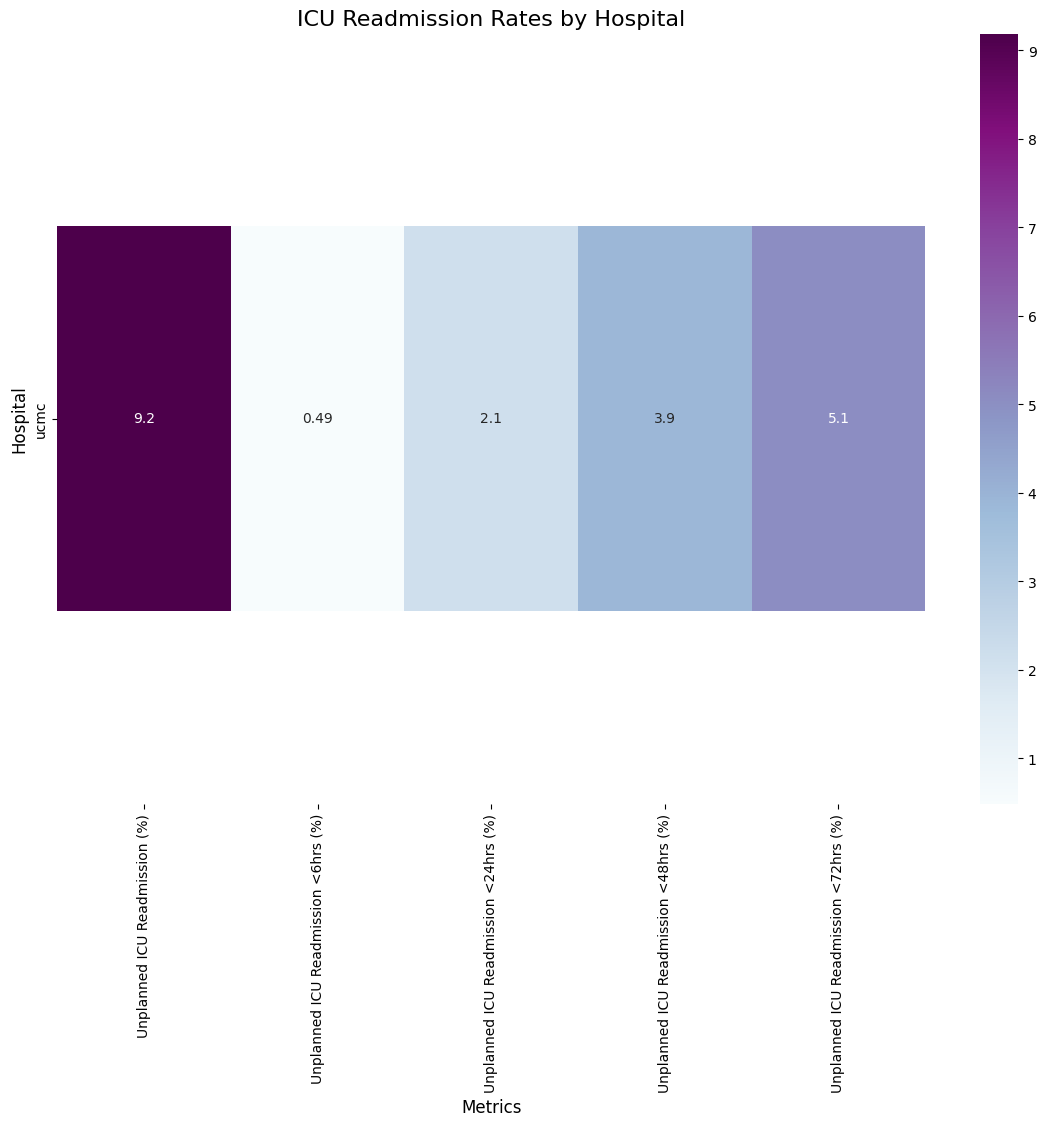

In [32]:
# Group the DataFrame by hospital category
hospital_groups = icu_final.groupby('hospital_category')

# Initialize an empty list to store table rows
table_data = []

# Loop over each hospital group to collect data
for hospital, group in hospital_groups:
    hospital_name = hospital.lower().replace(" ", "_")

    # Calculations
    total_unique_visits = group["linked_group"].nunique()
    unique_visits_with_procedures = group[group["procedural"] == True]["linked_group"].nunique()
    unique_visits_without_procedures = group[group["procedural"] == False]["linked_group"].nunique()

    all_icu_readmission = group[(group["ICU_readmission_hour"] > 0)]["linked_group"].nunique()
    all_icu_readmission_6hours = group[(group["ICU_readmission_hour"] < 6)]["linked_group"].nunique()
    all_icu_readmission_24hours = group[(group["ICU_readmission_hour"] < 24)]["linked_group"].nunique()
    all_icu_readmission_48hours = group[(group["ICU_readmission_hour"] < 48)]["linked_group"].nunique()
    all_icu_readmission_72hours = group[(group["ICU_readmission_hour"] < 72)]["linked_group"].nunique()

    unplanned_icu_readmission = group[(group["procedural"] == False) & (group["ICU_readmission_hour"] > 0)]["linked_group"].nunique()
    unplanned_icu_readmission_6hours = group[(group["procedural"] == False) & (group["ICU_readmission_hour"] < 6)]["linked_group"].nunique()
    unplanned_icu_readmission_24hours = group[(group["procedural"] == False) & (group["ICU_readmission_hour"] < 24)]["linked_group"].nunique()
    unplanned_icu_readmission_48hours = group[(group["procedural"] == False) & (group["ICU_readmission_hour"] < 48)]["linked_group"].nunique()
    unplanned_icu_readmission_72hours = group[(group["procedural"] == False) & (group["ICU_readmission_hour"] < 72)]["linked_group"].nunique()

    # Percentages
    all_icu_read = round((all_icu_readmission / total_unique_visits) * 100, 2)
    all_6hrs = round((all_icu_readmission_6hours / total_unique_visits) * 100, 2)
    all_24hrs = round((all_icu_readmission_24hours / total_unique_visits) * 100, 2)
    all_48hrs = round((all_icu_readmission_48hours / total_unique_visits) * 100, 2)
    all_72hrs = round((all_icu_readmission_72hours / total_unique_visits) * 100, 2)

    unplanned_icu_read = round((unplanned_icu_readmission / unique_visits_without_procedures) * 100, 2) if unique_visits_without_procedures > 0 else 0
    unplanned_6hrs = round((unplanned_icu_readmission_6hours / unique_visits_without_procedures) * 100, 2) if unique_visits_without_procedures > 0 else 0
    unplanned_24hrs = round((unplanned_icu_readmission_24hours / unique_visits_without_procedures) * 100, 2) if unique_visits_without_procedures > 0 else 0
    unplanned_48hrs = round((unplanned_icu_readmission_48hours / unique_visits_without_procedures) * 100, 2) if unique_visits_without_procedures > 0 else 0
    unplanned_72hrs = round((unplanned_icu_readmission_72hours / unique_visits_without_procedures) * 100, 2) if unique_visits_without_procedures > 0 else 0

    # Append a row for the current hospital
    table_data.append({
        "Hospital": hospital,
        "Total Unique Visits": total_unique_visits,
        "Planned Readmission (Procedural)": unique_visits_with_procedures,
        "Unplanned Readmission (Non-Procedural)": unique_visits_without_procedures,
        "All ICU Readmission (%)": all_icu_read,
        "Unplanned ICU Readmission (%)": unplanned_icu_read,
        "Unplanned ICU Readmission <6hrs (%)": unplanned_6hrs,
        "Unplanned ICU Readmission <24hrs (%)": unplanned_24hrs,
        "Unplanned ICU Readmission <48hrs (%)": unplanned_48hrs,
        "Unplanned ICU Readmission <72hrs (%)": unplanned_72hrs
    })

# Convert the data to a DataFrame for better visualization
icu_readmission_table = pd.DataFrame(table_data)
icu_readmission_table.to_csv(f'{output_path}/icu_readmission_table_{site_name}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv')

icu_readmission_table = icu_readmission_table.set_index("Hospital")

heatmap_data = icu_readmission_table[
    [
       # "All ICU Readmission (%)",
        "Unplanned ICU Readmission (%)",
        "Unplanned ICU Readmission <6hrs (%)",
        "Unplanned ICU Readmission <24hrs (%)",
        "Unplanned ICU Readmission <48hrs (%)",
        "Unplanned ICU Readmission <72hrs (%)",
    ]
]

# Create the heatmap with a red color scheme
plt.figure(figsize=(14, 10))  # Increased figure size for better layout
ax = sns.heatmap(
    heatmap_data, 
    annot=True, 
    cmap="BuPu", 
)

# Add labels and title
plt.title("ICU Readmission Rates by Hospital", fontsize=16)
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Hospital", fontsize=12)

ax.set_ylim(len(heatmap_data) + 0.5, - 0.5)

plt.savefig(f'{intermediate_output_path}/icu_readmission_heatmap_{site_name}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.png', dpi=300, bbox_inches='tight')
plt.show()

In [33]:
hospital_groups = icu_final.groupby('hospital_category')

for hospital, group in hospital_groups:
    hospital_name = hospital.lower().replace(" ", "_")

    # Calculations
    total_unique_visits = group["linked_group"].nunique()
    unique_visits_with_procedures = group[group["procedural"] == True]["linked_group"].nunique()
    unique_visits_without_procedures = group[group["procedural"] == False]["linked_group"].nunique()

    all_icu_readmission = group[(group["ICU_readmission_hour"] > 0)]["linked_group"].nunique()
    all_icu_readmission_6hours = group[(group["ICU_readmission_hour"] < 6)]["linked_group"].nunique()
    all_icu_readmission_24hours = group[(group["ICU_readmission_hour"] < 24)]["linked_group"].nunique()
    all_icu_readmission_48hours = group[(group["ICU_readmission_hour"] < 48)]["linked_group"].nunique()
    all_icu_readmission_72hours = group[(group["ICU_readmission_hour"] < 72)]["linked_group"].nunique()

    unplanned_icu_readmission = group[(group["procedural"] == False) & (group["ICU_readmission_hour"] > 0)]["linked_group"].nunique()
    unplanned_icu_readmission_6hours = group[(group["procedural"] == False) & (group["ICU_readmission_hour"] < 6)]["linked_group"].nunique()
    unplanned_icu_readmission_24hours = group[(group["procedural"] == False) & (group["ICU_readmission_hour"] < 24)]["linked_group"].nunique()
    unplanned_icu_readmission_48hours = group[(group["procedural"] == False) & (group["ICU_readmission_hour"] < 48)]["linked_group"].nunique()
    unplanned_icu_readmission_72hours = group[(group["procedural"] == False) & (group["ICU_readmission_hour"] < 72)]["linked_group"].nunique()

    # Percentages
    all_icu_read = round((all_icu_readmission / total_unique_visits) * 100, 2)
    all_6hrs = round((all_icu_readmission_6hours / total_unique_visits) * 100, 2)
    all_24hrs = round((all_icu_readmission_24hours / total_unique_visits) * 100, 2)
    all_48hrs = round((all_icu_readmission_48hours / total_unique_visits) * 100, 2)
    all_72hrs = round((all_icu_readmission_72hours / total_unique_visits) * 100, 2)

    unplanned_icu_read = round((unplanned_icu_readmission / unique_visits_without_procedures) * 100, 2) if unique_visits_without_procedures > 0 else 0
    unplanned_6hrs = round((unplanned_icu_readmission_6hours / unique_visits_without_procedures) * 100, 2) if unique_visits_without_procedures > 0 else 0
    unplanned_24hrs = round((unplanned_icu_readmission_24hours / unique_visits_without_procedures) * 100, 2) if unique_visits_without_procedures > 0 else 0
    unplanned_48hrs = round((unplanned_icu_readmission_48hours / unique_visits_without_procedures) * 100, 2) if unique_visits_without_procedures > 0 else 0
    unplanned_72hrs = round((unplanned_icu_readmission_72hours / unique_visits_without_procedures) * 100, 2) if unique_visits_without_procedures > 0 else 0

    # Save as unique variables
    globals()[f"{hospital_name}_total_unique_visits"] = total_unique_visits
    globals()[f"{hospital_name}_unique_visits_with_procedures"] = unique_visits_with_procedures
    globals()[f"{hospital_name}_unique_visits_without_procedures"] = unique_visits_without_procedures

    globals()[f"{hospital_name}_all_icu_readmission"] = all_icu_readmission
    globals()[f"{hospital_name}_all_icu_readmission_6hours"] = all_icu_readmission_6hours
    globals()[f"{hospital_name}_all_icu_readmission_24hours"] = all_icu_readmission_24hours
    globals()[f"{hospital_name}_all_icu_readmission_48hours"] = all_icu_readmission_48hours
    globals()[f"{hospital_name}_all_icu_readmission_72hours"] = all_icu_readmission_72hours

    globals()[f"{hospital_name}_unplanned_icu_readmission"] = unplanned_icu_readmission
    globals()[f"{hospital_name}_unplanned_icu_readmission_6hours"] = unplanned_icu_readmission_6hours
    globals()[f"{hospital_name}_unplanned_icu_readmission_24hours"] = unplanned_icu_readmission_24hours
    globals()[f"{hospital_name}_unplanned_icu_readmission_48hours"] = unplanned_icu_readmission_48hours
    globals()[f"{hospital_name}_unplanned_icu_readmission_72hours"] = unplanned_icu_readmission_72hours

    globals()[f"{hospital_name}_all_icu_read"] = all_icu_read
    globals()[f"{hospital_name}_all_6hrs"] = all_6hrs
    globals()[f"{hospital_name}_all_24hrs"] = all_24hrs
    globals()[f"{hospital_name}_all_48hrs"] = all_48hrs
    globals()[f"{hospital_name}_all_72hrs"] = all_72hrs

    globals()[f"{hospital_name}_unplanned_icu_read"] = unplanned_icu_read
    globals()[f"{hospital_name}_unplanned_6hrs"] = unplanned_6hrs
    globals()[f"{hospital_name}_unplanned_24hrs"] = unplanned_24hrs
    globals()[f"{hospital_name}_unplanned_48hrs"] = unplanned_48hrs
    globals()[f"{hospital_name}_unplanned_72hrs"] = unplanned_72hrs

    # Output
    print(f"Hospital: {hospital}")
    print(f"  Total unique hospitalization_id: {total_unique_visits}")
    print(f"  Planned readmission (procedural): {unique_visits_with_procedures}")
    print(f"  Unplanned readmission (non-procedural): {unique_visits_without_procedures}")

    print(f"  All ICU readmission ({all_icu_readmission}/{total_unique_visits}): {all_icu_read}%")
    print(f"  All ICU readmission <6hr ({all_icu_readmission_6hours}/{total_unique_visits}): {all_6hrs}%")
    print(f"  All ICU readmission <24hr ({all_icu_readmission_24hours}/{total_unique_visits}): {all_24hrs}%")
    print(f"  All ICU readmission <48hr ({all_icu_readmission_48hours}/{total_unique_visits}): {all_48hrs}%")
    print(f"  All ICU readmission <72hr ({all_icu_readmission_72hours}/{total_unique_visits}): {all_72hrs}%")

    print(f"  Unplanned ICU readmission ({unplanned_icu_readmission}/{unique_visits_without_procedures}): {unplanned_icu_read}%")
    print(f"  Unplanned ICU readmission <6hr ({unplanned_icu_readmission_6hours}/{unique_visits_without_procedures}): {unplanned_6hrs}%")
    print(f"  Unplanned ICU readmission <24hr ({unplanned_icu_readmission_24hours}/{unique_visits_without_procedures}): {unplanned_24hrs}%")
    print(f"  Unplanned ICU readmission <48hr ({unplanned_icu_readmission_48hours}/{unique_visits_without_procedures}): {unplanned_48hrs}%")
    print(f"  Unplanned ICU readmission <72hr ({unplanned_icu_readmission_72hours}/{unique_visits_without_procedures}): {unplanned_72hrs}%")
    print("\n")


Hospital: ucmc
  Total unique hospitalization_id: 9397
  Planned readmission (procedural): 183
  Unplanned readmission (non-procedural): 9214
  All ICU readmission (1030/9397): 10.96%
  All ICU readmission <6hr (46/9397): 0.49%
  All ICU readmission <24hr (209/9397): 2.22%
  All ICU readmission <48hr (393/9397): 4.18%
  All ICU readmission <72hr (514/9397): 5.47%
  Unplanned ICU readmission (847/9214): 9.19%
  Unplanned ICU readmission <6hr (45/9214): 0.49%
  Unplanned ICU readmission <24hr (196/9214): 2.13%
  Unplanned ICU readmission <48hr (359/9214): 3.9%
  Unplanned ICU readmission <72hr (466/9214): 5.06%




# vasopressor

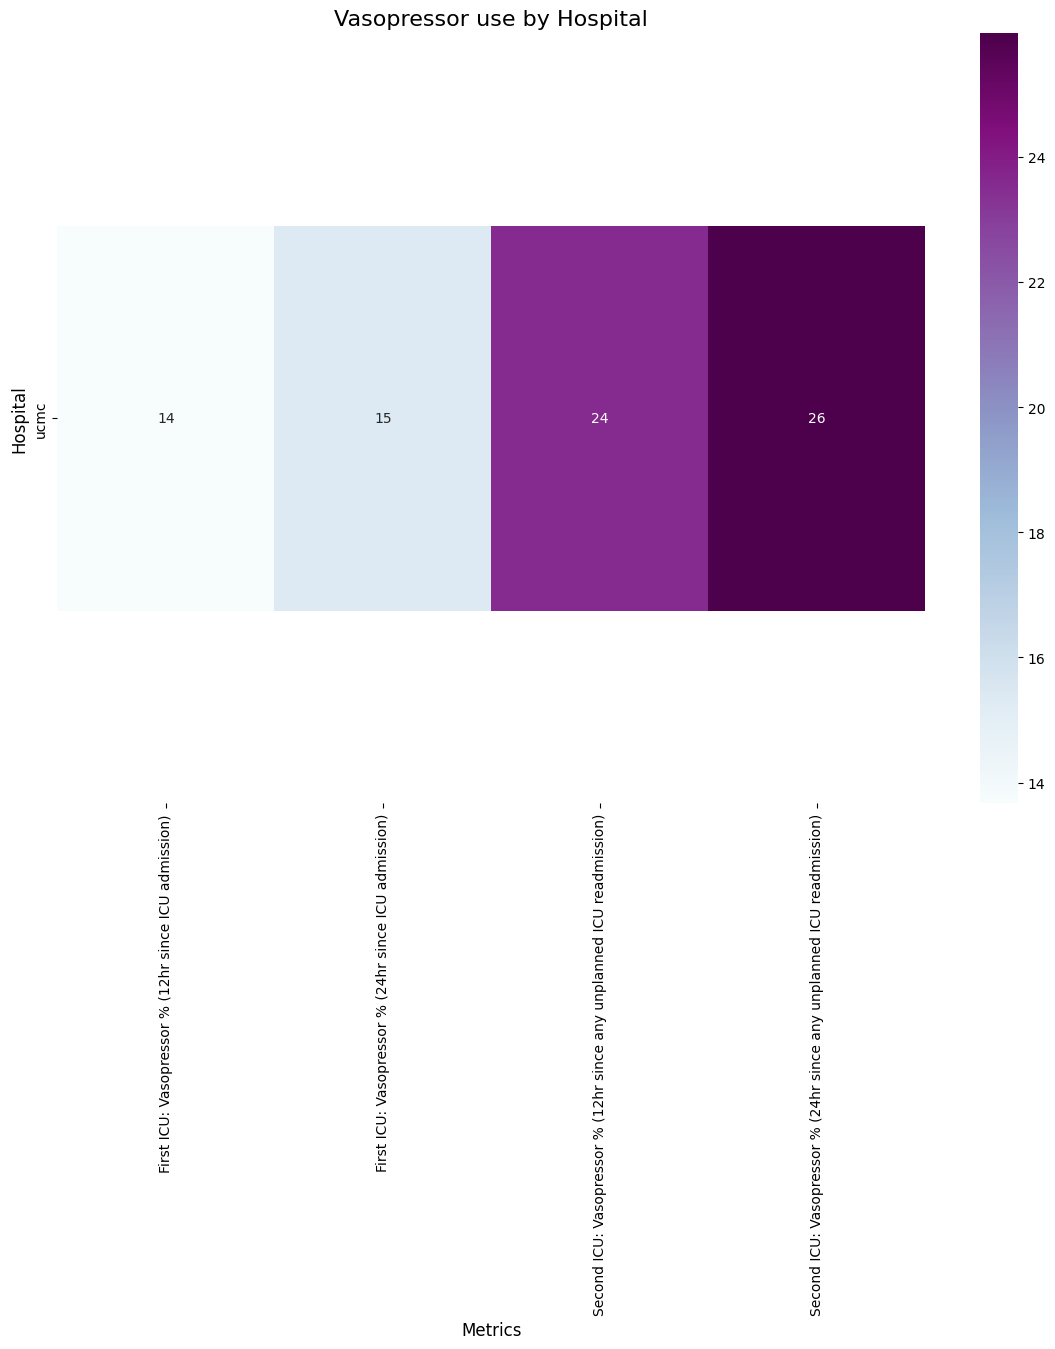

In [35]:
# Group the DataFrame by hospital category
hospital_groups = icu_final.groupby('hospital_category')

# Initialize an empty list to store table rows
table_data = []

# Loop over each hospital group to collect data
for hospital, group in hospital_groups:
    # Generate hospital-specific variable prefix
    hospital_name = hospital.lower().replace(" ", "_")

    # Retrieve previously saved variables
    total_unique_visits = globals().get(f"{hospital_name}_total_unique_visits", 0)
    unplanned_icu_readmission = globals().get(f"{hospital_name}_unplanned_icu_readmission", 0)
    unplanned_icu_readmission_6hours = globals().get(f"{hospital_name}_unplanned_icu_readmission_6hours", 0)
    unplanned_icu_readmission_24hours = globals().get(f"{hospital_name}_unplanned_icu_readmission_24hours", 0)
    unplanned_icu_readmission_48hours = globals().get(f"{hospital_name}_unplanned_icu_readmission_48hours", 0)
    unplanned_icu_readmission_72hours = globals().get(f"{hospital_name}_unplanned_icu_readmission_72hours", 0)

    # Current calculations
    total_unique_visits = group["linked_group"].nunique()
    vasopressin_count_12hr = group[(group["vaso_first_12hr"].isna() == False)]["linked_group"].nunique()
    vasopressin_count_24hr = group[(group["vaso_first_24hr"].isna() == False)]["linked_group"].nunique()
    unplanned_firsticu_vasopressin_pct_12hr = round((vasopressin_count_12hr / total_unique_visits) * 100, 2)
    unplanned_firsticu_vasopressin_pct_24hr = round((vasopressin_count_24hr / total_unique_visits) * 100, 2)

    unplanned_secondicu_vasopressin_12hr = group[(group["procedural"] == False) & (group["vaso_second_12hr"].isna() == False)]["linked_group"].nunique()
    unplanned_secondicu_vasopressin_6hr_12hr = group[(group["procedural"] == False) & (group["vaso_second_12hr"].isna() == False) & (group["ICU_readmission_hour"] < 6)]["linked_group"].nunique()
    unplanned_secondicu_vasopressin_24hr_12hr = group[(group["procedural"] == False) & (group["vaso_second_12hr"].isna() == False) & (group["ICU_readmission_hour"] < 24)]["linked_group"].nunique()
    unplanned_secondicu_vasopressin_48hr_12hr = group[(group["procedural"] == False) & (group["vaso_second_12hr"].isna() == False) & (group["ICU_readmission_hour"] < 48)]["linked_group"].nunique()
    unplanned_secondicu_vasopressin_72hr_12hr = group[(group["procedural"] == False) & (group["vaso_second_12hr"].isna() == False) & (group["ICU_readmission_hour"] < 72)]["linked_group"].nunique()
    
    unplanned_secondicu_vasopressin_24hr = group[(group["procedural"] == False) & (group["vaso_second_24hr"].isna() == False)]["linked_group"].nunique()
    unplanned_secondicu_vasopressin_6hr_24hr = group[(group["procedural"] == False) & (group["vaso_second_24hr"].isna() == False) & (group["ICU_readmission_hour"] < 6)]["linked_group"].nunique()
    unplanned_secondicu_vasopressin_24hr_24hr = group[(group["procedural"] == False) & (group["vaso_second_24hr"].isna() == False) & (group["ICU_readmission_hour"] < 24)]["linked_group"].nunique()
    unplanned_secondicu_vasopressin_48hr_24hr = group[(group["procedural"] == False) & (group["vaso_second_24hr"].isna() == False) & (group["ICU_readmission_hour"] < 48)]["linked_group"].nunique()
    unplanned_secondicu_vasopressin_72hr_24hr = group[(group["procedural"] == False) & (group["vaso_second_24hr"].isna() == False) & (group["ICU_readmission_hour"] < 72)]["linked_group"].nunique()
    
    unplanned_secondicu_vasopressin_pct_12hr = round((unplanned_secondicu_vasopressin_12hr / unplanned_icu_readmission) * 100, 2) if unplanned_icu_readmission > 0 else 0
    unplanned_secondicu_vasopressin_6hr_pct_12hr = round((unplanned_secondicu_vasopressin_6hr_12hr / unplanned_icu_readmission_6hours) * 100, 2) if unplanned_icu_readmission_6hours > 0 else 0
    unplanned_secondicu_vasopressin_24hr_pct_12hr = round((unplanned_secondicu_vasopressin_24hr_12hr / unplanned_icu_readmission_24hours) * 100, 2) if unplanned_icu_readmission_24hours > 0 else 0
    unplanned_secondicu_vasopressin_48hr_pct_12hr = round((unplanned_secondicu_vasopressin_48hr_12hr / unplanned_icu_readmission_48hours) * 100, 2) if unplanned_icu_readmission_48hours > 0 else 0
    unplanned_secondicu_vasopressin_72hr_pct_12hr = round((unplanned_secondicu_vasopressin_72hr_12hr / unplanned_icu_readmission_72hours) * 100, 2) if unplanned_icu_readmission_72hours > 0 else 0
    
    unplanned_secondicu_vasopressin_pct_24hr = round((unplanned_secondicu_vasopressin_24hr / unplanned_icu_readmission) * 100, 2) if unplanned_icu_readmission > 0 else 0
    unplanned_secondicu_vasopressin_6hr_pct_24hr = round((unplanned_secondicu_vasopressin_6hr_24hr / unplanned_icu_readmission_6hours) * 100, 2) if unplanned_icu_readmission_6hours > 0 else 0
    unplanned_secondicu_vasopressin_24hr_pct_24hr = round((unplanned_secondicu_vasopressin_24hr_24hr / unplanned_icu_readmission_24hours) * 100, 2) if unplanned_icu_readmission_24hours > 0 else 0
    unplanned_secondicu_vasopressin_48hr_pct_24hr = round((unplanned_secondicu_vasopressin_48hr_24hr / unplanned_icu_readmission_48hours) * 100, 2) if unplanned_icu_readmission_48hours > 0 else 0
    unplanned_secondicu_vasopressin_72hr_pct_24hr = round((unplanned_secondicu_vasopressin_72hr_24hr / unplanned_icu_readmission_72hours) * 100, 2) if unplanned_icu_readmission_72hours > 0 else 0
    
    
    # Append a row for the current hospital
    table_data.append({
        "Hospital": hospital,
        "First ICU: Vasopressor % (12hr since ICU admission)": unplanned_firsticu_vasopressin_pct_12hr,
        "First ICU: Vasopressor % (24hr since ICU admission)": unplanned_firsticu_vasopressin_pct_24hr,
        "Second ICU: Vasopressor % (12hr since any unplanned ICU readmission)": unplanned_secondicu_vasopressin_pct_12hr,
        "Second ICU: Vasopressor % (12hr since <24hr unplanned ICU readmission)": unplanned_secondicu_vasopressin_24hr_pct_12hr,
        "Second ICU: Vasopressor % (12hr since <48hr unplanned ICU readmission)": unplanned_secondicu_vasopressin_48hr_pct_12hr,
        "Second ICU: Vasopressor % (12hr since <72hr unplanned ICU readmission)": unplanned_secondicu_vasopressin_72hr_pct_12hr,
        "Second ICU: Vasopressor % (24hr since any unplanned ICU readmission)": unplanned_secondicu_vasopressin_pct_24hr,
        "Second ICU: Vasopressor % (24hr since <24hr unplanned ICU readmission)": unplanned_secondicu_vasopressin_24hr_pct_24hr,
        "Second ICU: Vasopressor % (24hr since <48hr unplanned ICU readmission)": unplanned_secondicu_vasopressin_48hr_pct_24hr,
        "Second ICU: Vasopressor % (24hr since <72hr unplanned ICU readmission)": unplanned_secondicu_vasopressin_72hr_pct_24hr,
    })

# Convert the data to a DataFrame for better visualization
vasopressor_table = pd.DataFrame(table_data)
vasopressor_table.to_csv(f'{output_path}/vasopressor_table_{site_name}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv')

vasopressor_table = vasopressor_table.set_index("Hospital")

heatmap_data = vasopressor_table[
    [
       # "All ICU Readmission (%)",
        "First ICU: Vasopressor % (12hr since ICU admission)",
        "First ICU: Vasopressor % (24hr since ICU admission)",
        "Second ICU: Vasopressor % (12hr since any unplanned ICU readmission)",
        "Second ICU: Vasopressor % (24hr since any unplanned ICU readmission)",
    ]
]

# Create the heatmap with a red color scheme
plt.figure(figsize=(14, 10))  # Increased figure size for better layout
ax = sns.heatmap(
    heatmap_data, 
    annot=True, 
    cmap="BuPu",  # Use the "Reds" colormap for a red theme
    #fmt=".1f", 
    #linewidths=0.5, 
    #cbar_kws={"shrink": 0.8}  # Shrink color bar for better fit
)

# Add labels and title
plt.title("Vasopressor use by Hospital", fontsize=16)
#plt.tight_layout()
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Hospital", fontsize=12)
#plt.xticks(rotation=45, ha='right')


# Ensure proper layout
#plt.tight_layout()  # Automatically adjust elements to fit into the figure
#plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.2)  # Extra manual adjustments


ax.set_ylim(len(heatmap_data) + 0.5, - 0.5)
plt.savefig(f'{intermediate_output_path}/vasopressor_heatmap_{site_name}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.png', dpi=300, bbox_inches='tight')
plt.show()

# Support device use

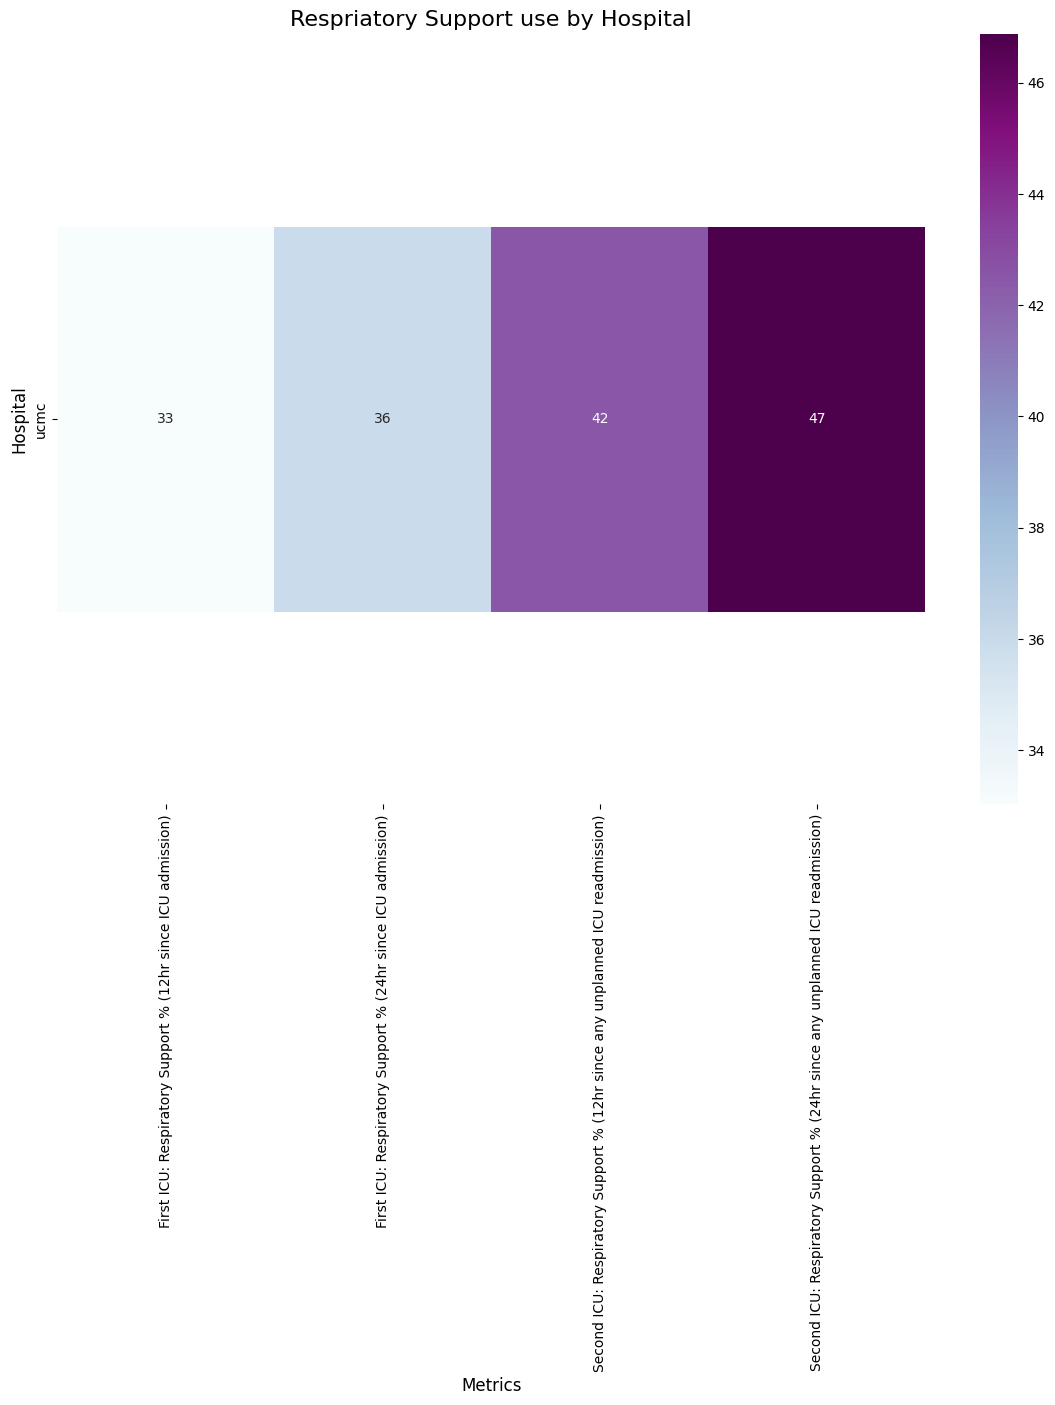

In [36]:
# Group the DataFrame by hospital category
hospital_groups = icu_final.groupby('hospital_category')

# Initialize an empty list to store table rows
table_data = []

# Loop over each hospital group to collect data
for hospital, group in hospital_groups:
    # Generate hospital-specific variable prefix
    hospital_name = hospital.lower().replace(" ", "_")

    # Retrieve previously saved variables
    total_unique_visits = globals().get(f"{hospital_name}_total_unique_visits", 0)
    unplanned_icu_readmission = globals().get(f"{hospital_name}_unplanned_icu_readmission", 0)
    unplanned_icu_readmission_6hours = globals().get(f"{hospital_name}_unplanned_icu_readmission_6hours", 0)
    unplanned_icu_readmission_24hours = globals().get(f"{hospital_name}_unplanned_icu_readmission_24hours", 0)
    unplanned_icu_readmission_48hours = globals().get(f"{hospital_name}_unplanned_icu_readmission_48hours", 0)
    unplanned_icu_readmission_72hours = globals().get(f"{hospital_name}_unplanned_icu_readmission_72hours", 0)

    # Current calculations
    total_unique_visits = group["linked_group"].nunique()
    resp_support_count_12hr = group[(group["resp_support_first_12hr"].isna() == False)]["linked_group"].nunique()
    resp_support_count_24hr = group[(group["resp_support_first_24hr"].isna() == False)]["linked_group"].nunique()
    unplanned_firsticu_resp_support_pct_12hr = round((resp_support_count_12hr / total_unique_visits) * 100, 2)
    unplanned_firsticu_resp_support_pct_24hr = round((resp_support_count_24hr / total_unique_visits) * 100, 2)

    unplanned_secondicu_resp_support_12hr = group[(group["procedural"] == False) & (group["resp_support_second_12hr"].isna() == False)]["linked_group"].nunique()
    unplanned_secondicu_resp_support_6hr_12hr = group[(group["procedural"] == False) & (group["resp_support_second_12hr"].isna() == False) & (group["ICU_readmission_hour"] < 6)]["linked_group"].nunique()
    unplanned_secondicu_resp_support_24hr_12hr = group[(group["procedural"] == False) & (group["resp_support_second_12hr"].isna() == False) & (group["ICU_readmission_hour"] < 24)]["linked_group"].nunique()
    unplanned_secondicu_resp_support_48hr_12hr = group[(group["procedural"] == False) & (group["resp_support_second_12hr"].isna() == False) & (group["ICU_readmission_hour"] < 48)]["linked_group"].nunique()
    unplanned_secondicu_resp_support_72hr_12hr = group[(group["procedural"] == False) & (group["resp_support_second_12hr"].isna() == False) & (group["ICU_readmission_hour"] < 72)]["linked_group"].nunique()
    
    unplanned_secondicu_resp_support_24hr = group[(group["procedural"] == False) & (group["resp_support_second_24hr"].isna() == False)]["linked_group"].nunique()
    unplanned_secondicu_resp_support_6hr_24hr = group[(group["procedural"] == False) & (group["resp_support_second_24hr"].isna() == False) & (group["ICU_readmission_hour"] < 6)]["linked_group"].nunique()
    unplanned_secondicu_resp_support_24hr_24hr = group[(group["procedural"] == False) & (group["resp_support_second_24hr"].isna() == False) & (group["ICU_readmission_hour"] < 24)]["linked_group"].nunique()
    unplanned_secondicu_resp_support_48hr_24hr = group[(group["procedural"] == False) & (group["resp_support_second_24hr"].isna() == False) & (group["ICU_readmission_hour"] < 48)]["linked_group"].nunique()
    unplanned_secondicu_resp_support_72hr_24hr = group[(group["procedural"] == False) & (group["resp_support_second_24hr"].isna() == False) & (group["ICU_readmission_hour"] < 72)]["linked_group"].nunique()
    
    unplanned_secondicu_resp_support_pct_12hr = round((unplanned_secondicu_resp_support_12hr / unplanned_icu_readmission) * 100, 2) if unplanned_icu_readmission > 0 else 0
    unplanned_secondicu_resp_support_6hr_pct_12hr = round((unplanned_secondicu_resp_support_6hr_12hr / unplanned_icu_readmission_6hours) * 100, 2) if unplanned_icu_readmission_6hours > 0 else 0
    unplanned_secondicu_resp_support_24hr_pct_12hr = round((unplanned_secondicu_resp_support_24hr_12hr / unplanned_icu_readmission_24hours) * 100, 2) if unplanned_icu_readmission_24hours > 0 else 0
    unplanned_secondicu_resp_support_48hr_pct_12hr = round((unplanned_secondicu_resp_support_48hr_12hr / unplanned_icu_readmission_48hours) * 100, 2) if unplanned_icu_readmission_48hours > 0 else 0
    unplanned_secondicu_resp_support_72hr_pct_12hr = round((unplanned_secondicu_resp_support_72hr_12hr / unplanned_icu_readmission_72hours) * 100, 2) if unplanned_icu_readmission_72hours > 0 else 0

    unplanned_secondicu_resp_support_pct_24hr = round((unplanned_secondicu_resp_support_24hr / unplanned_icu_readmission) * 100, 2) if unplanned_icu_readmission > 0 else 0
    unplanned_secondicu_resp_support_6hr_pct_24hr = round((unplanned_secondicu_resp_support_6hr_24hr / unplanned_icu_readmission_6hours) * 100, 2) if unplanned_icu_readmission_6hours > 0 else 0
    unplanned_secondicu_resp_support_24hr_pct_24hr = round((unplanned_secondicu_resp_support_24hr_24hr / unplanned_icu_readmission_24hours) * 100, 2) if unplanned_icu_readmission_24hours > 0 else 0
    unplanned_secondicu_resp_support_48hr_pct_24hr = round((unplanned_secondicu_resp_support_48hr_24hr / unplanned_icu_readmission_48hours) * 100, 2) if unplanned_icu_readmission_48hours > 0 else 0
    unplanned_secondicu_resp_support_72hr_pct_24hr = round((unplanned_secondicu_resp_support_72hr_24hr/ unplanned_icu_readmission_72hours) * 100, 2) if unplanned_icu_readmission_72hours > 0 else 0
    
    
    # Append a row for the current hospital
    table_data.append({
        "Hospital": hospital,
        "First ICU: Respiratory Support % (12hr since ICU admission)": unplanned_firsticu_resp_support_pct_12hr,
        "First ICU: Respiratory Support % (24hr since ICU admission)": unplanned_firsticu_resp_support_pct_24hr,
        "Second ICU: Respiratory Support % (12hr since any unplanned ICU readmission)": unplanned_secondicu_resp_support_pct_12hr,
        "Second ICU: Respiratory Support % (12hr since <24hr unplanned ICU readmission)": unplanned_secondicu_resp_support_24hr_pct_12hr,
        "Second ICU: Respiratory Support % (12hr since <48hr unplanned ICU readmission)": unplanned_secondicu_resp_support_48hr_pct_12hr,
        "Second ICU: Respiratory Support % (12hr since <72hr unplanned ICU readmission)": unplanned_secondicu_resp_support_72hr_pct_12hr,
        "Second ICU: Respiratory Support % (24hr since any unplanned ICU readmission)": unplanned_secondicu_resp_support_pct_24hr,
        "Second ICU: Respiratory Support % (24hr since <24hr unplanned ICU readmission)": unplanned_secondicu_resp_support_24hr_pct_24hr,
        "Second ICU: Respiratory Support % (24hr since <48hr unplanned ICU readmission)": unplanned_secondicu_resp_support_48hr_pct_24hr,
        "Second ICU: Respiratory Support % (24hr since <72hr unplanned ICU readmission)": unplanned_secondicu_resp_support_72hr_pct_24hr,
    })

# Convert the data to a DataFrame for better visualization
resp_support_table = pd.DataFrame(table_data)

resp_support_table.to_csv(f'{output_path}/resp_support_table_{site_name}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv')

resp_support_table = resp_support_table.set_index("Hospital")

heatmap_data = resp_support_table[
    [
       # "All ICU Readmission (%)",
        "First ICU: Respiratory Support % (12hr since ICU admission)",
        "First ICU: Respiratory Support % (24hr since ICU admission)",
        "Second ICU: Respiratory Support % (12hr since any unplanned ICU readmission)",
        "Second ICU: Respiratory Support % (24hr since any unplanned ICU readmission)",
    ]
]

# Create the heatmap with a red color scheme
plt.figure(figsize=(14, 10))  # Increased figure size for better layout
ax = sns.heatmap(
    heatmap_data, 
    annot=True, 
    cmap="BuPu",  # Use the "Reds" colormap for a red theme
)

# Add labels and title
plt.title("Respriatory Support use by Hospital", fontsize=16)
#plt.tight_layout()
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Hospital", fontsize=12)

ax.set_ylim(len(heatmap_data) + 0.5, - 0.5)
plt.savefig(f'{intermediate_output_path}/resp_support_heatmap_{site_name}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.png', dpi=300, bbox_inches='tight')
plt.show()

# Generate Sankey Plot

In [37]:
dropped_deaths_df2 = dropped_deaths_df.rename(columns={
    'in_dttm': 'earliest_location_start',
    'out_dttm': 'latest_location_end'
})

dropped_df_icu_discharge2 = dropped_df_icu_discharge.rename(columns={
    'in_dttm': 'earliest_location_start',
    'out_dttm': 'latest_location_end'
})

print(dropped_deaths_df2["linked_group"].nunique())
print(dropped_df_icu_discharge2["linked_group"].nunique())

600
1928


In [38]:
icu_df7_death = pd.concat([dropped_df_icu_discharge2[["patient_id","linked_group","earliest_location_start",
                                                    "latest_location_end","location_category","procedural"]], 
                           dropped_deaths_df2[["patient_id","linked_group","earliest_location_start",
                                                    "latest_location_end","location_category","procedural"]]], axis=0)
icu_df7_death = pd.concat([icu_df7_death, icu_df7[["patient_id","linked_group","earliest_location_start",
                                                    "latest_location_end","location_category","procedural"]]], axis=0)

icu_df7_death = pd.merge(icu_df7_death,patient[["patient_id","death_dttm"]],on="patient_id",how="left")

icu_df7_death = pd.merge(icu_df7_death,df_idlist,on="patient_id",how="left")
icu_df7_death = pd.merge(icu_df7_death,hosp[["hospitalization_id","discharge_category"]],on="hospitalization_id",how="left")
icu_df7_death = pd.merge(icu_df7_death, hospital_block2, on="linked_group", how="left").drop_duplicates()

print("Number of rows in df:",len(icu_df7_death))
print("Number of unique patient_id:", icu_df7_death["patient_id"].nunique())
print("Number of unique linked hospitalization_id:", icu_df7_death["linked_group"].nunique())
icu_df7_death.head()

Number of rows in df: 58596
Number of unique patient_id: 10202
Number of unique linked hospitalization_id: 11925


patient_id  linked_group   earliest_location_start  \
0    1000604             3 2021-06-12 01:18:00+00:00   
1    1001947             7 2020-06-03 01:09:00+00:00   
2    1003031            10 2020-01-17 07:06:00+00:00   
3    1003031            10 2020-01-17 10:29:00+00:00   
4    1008420            28 2020-06-23 12:10:00+00:00   

        latest_location_end location_category  procedural death_dttm  \
0 2021-06-16 18:00:00+00:00               ICU       False        NaT   
1 2020-06-15 14:03:00+00:00               ICU       False        NaT   
2 2020-01-17 10:29:00+00:00        Procedural       False        NaT   
3 2020-01-18 15:47:00+00:00               ICU       False        NaT   
4 2020-06-23 17:29:00+00:00                ER       False        NaT   

  hospitalization_id discharge_category hospital_category  
0           17736226               Home              ucmc  
1            7130769               Home              ucmc  
2           26373873               Home              ucmc  
3           26373873               Home              ucmc  
4           25574035            Expired              ucmc

In [39]:
def mark_deaths(df):
    # Ensure the columns are in datetime format
    df['death_dttm'] = pd.to_datetime(df['death_dttm'], errors='coerce').dt.tz_localize(None)
    df['earliest_location_start'] = pd.to_datetime(df['earliest_location_start'], errors='coerce').dt.tz_localize(None)
    df['latest_location_end'] = pd.to_datetime(df['latest_location_end'], errors='coerce').dt.tz_localize(None)

    # Create the location_category_death column as a copy of location_category
    df['location_category_death'] = df['location_category']

    # Sort the dataframe by hospitalization_id and earliest_location_start to ensure order
    df = df.sort_values(by=['linked_group', 'earliest_location_start'])

    # Vectorized condition to check if death_dttm is between earliest_location_start and latest_location_end
    death_condition = (
        df['death_dttm'].notna() & 
        (df['earliest_location_start'] <= df['death_dttm']) & 
        (df['death_dttm'] <= df['latest_location_end'])
    )

    # Get unique hospitalization_ids where death occurs during the stay
    death_hosp_ids = df.loc[death_condition, 'linked_group'].unique()

    # Get the last row of each hospitalization where death occurs
    death_rows = df[df['linked_group'].isin(death_hosp_ids)].groupby('linked_group').last().reset_index()

    # Modify those rows to represent the 'Death' event
    death_rows['location_category_death'] = 'Died'
    death_rows['earliest_location_start'] = death_rows['latest_location_end'] + pd.Timedelta(seconds=1)
    death_rows['latest_location_end'] = death_rows['earliest_location_start']  # Ensure 'Death' row has valid time window

    # Concatenate the new 'Death' rows to the original dataframe
    df = pd.concat([df, death_rows], ignore_index=True)

    # Sort the dataframe again to ensure 'Death' rows come after the original locations
    df = df.sort_values(by=['linked_group', 'earliest_location_start']).reset_index(drop=True)

    return df
# Apply the function to the DataFrame
icu_df7_death = mark_deaths(icu_df7_death)

# Output the results
print("Number of dead patients:", icu_df7_death[icu_df7_death["location_category_death"] == "Died"]["linked_group"].nunique())
print("Number of rows in df:", len(icu_df7_death))
print("Number of unique hospitalization_id:", icu_df7_death["linked_group"].nunique())
icu_df7_death.head()

Number of dead patients: 860
Number of rows in df: 59456
Number of unique hospitalization_id: 11925


patient_id  linked_group earliest_location_start latest_location_end  \
0    1000252             1     2020-11-23 05:34:00 2020-11-23 16:21:00   
1    1000252             1     2020-11-23 16:21:00 2020-11-25 21:22:00   
2    1000252             1     2020-11-25 21:22:00 2020-11-26 18:27:00   
3    1000581             2     2021-03-17 03:06:00 2021-03-17 09:30:00   
4    1000581             2     2021-03-17 09:30:00 2021-03-25 20:03:00   

  location_category  procedural death_dttm hospitalization_id  \
0        Procedural       False        NaT           24520276   
1               ICU       False        NaT           24520276   
2              Ward       False        NaT           24520276   
3                ER        True        NaT           13950689   
4              Ward        True        NaT           13950689   

         discharge_category hospital_category location_category_death  
0                      Home              ucmc              Procedural  
1                      Home              ucmc                     ICU  
2                      Home              ucmc                    Ward  
3  Skilled Nursing Facility              ucmc                      ER  
4  Skilled Nursing Facility              ucmc                    Ward

In [40]:
icu_df7_death[icu_df7_death["location_category_death"]=="Died"][["linked_group",
                                                                  "earliest_location_start",
                                                                 "latest_location_end",
                                                                 "death_dttm",
                                                                 "location_category",
                                                                 "location_category_death"]].head()

linked_group earliest_location_start latest_location_end  \
28              9     2020-12-09 09:25:01 2020-12-09 09:25:01   
66             19     2021-12-12 11:11:01 2021-12-12 11:11:01   
101            30     2021-04-02 01:17:01 2021-04-02 01:17:01   
137            39     2020-04-06 10:55:01 2020-04-06 10:55:01   
166            46     2020-03-17 02:03:01 2020-03-17 02:03:01   

             death_dttm location_category location_category_death  
28  2020-12-09 01:36:00               ICU                    Died  
66  2021-12-12 07:50:00               ICU                    Died  
101 2021-03-30 00:00:00        Procedural                    Died  
137 2020-04-06 10:55:00               ICU                    Died  
166 2020-03-16 00:00:00               ICU                    Died

## This code chunk takes longer to run: 

In [41]:
icu_df7_death.head()

patient_id  linked_group earliest_location_start latest_location_end  \
0    1000252             1     2020-11-23 05:34:00 2020-11-23 16:21:00   
1    1000252             1     2020-11-23 16:21:00 2020-11-25 21:22:00   
2    1000252             1     2020-11-25 21:22:00 2020-11-26 18:27:00   
3    1000581             2     2021-03-17 03:06:00 2021-03-17 09:30:00   
4    1000581             2     2021-03-17 09:30:00 2021-03-25 20:03:00   

  location_category  procedural death_dttm hospitalization_id  \
0        Procedural       False        NaT           24520276   
1               ICU       False        NaT           24520276   
2              Ward       False        NaT           24520276   
3                ER        True        NaT           13950689   
4              Ward        True        NaT           13950689   

         discharge_category hospital_category location_category_death  
0                      Home              ucmc              Procedural  
1                      Home              ucmc                     ICU  
2                      Home              ucmc                    Ward  
3  Skilled Nursing Facility              ucmc                      ER  
4  Skilled Nursing Facility              ucmc                    Ward

In [42]:
# Function to collapse segments
def collapse_segments(df):
    df = df.sort_values('earliest_location_start').reset_index(drop=True)
    df['is_icu_in_location_category'] = (df['location_category'] == 'ICU')
    df['loc_cat_change'] = (df['location_category_death'] != df['location_category_death'].shift(1)).astype(int)
    df['segment_id'] = df['loc_cat_change'].cumsum()

    grouped = df.groupby(['segment_id', 'location_category_death']).agg({
        'earliest_location_start': 'min',
        'latest_location_end': 'max',
        'is_icu_in_location_category': 'max'
    }).reset_index()

    grouped['linked_group'] = df['linked_group'].iloc[0]
    grouped = grouped[['linked_group', 'segment_id', 'earliest_location_start', 'latest_location_end', 'location_category_death', 'is_icu_in_location_category']]

    icu_segments = grouped[grouped['is_icu_in_location_category'] == 1]
    if icu_segments.empty:
        return pd.DataFrame()

    first_icu_index = icu_segments.index[0]
    grouped['segment_rank'] = None
    grouped.loc[first_icu_index:, 'segment_rank'] = range(1, len(grouped.loc[first_icu_index:]) + 1)
    grouped['segment_rank'] = grouped['segment_rank'].ffill()

    max_segment_rank = grouped['segment_rank'].dropna().max()
    grouped['max_segment_rank'] = max_segment_rank
    grouped = grouped.drop(columns=['is_icu_in_location_category'])

    return grouped

# Apply the collapse_segments function using groupby and dictionary comprehension
collapsed_adt_dict = {
    hospital: group[['linked_group', 'earliest_location_start', 'latest_location_end', 'location_category', 'location_category_death']] \
        .groupby('linked_group', group_keys=False).apply(collapse_segments).reset_index(drop=True)
    for hospital, group in tqdm(icu_df7_death[icu_df7_death["procedural"] == False].groupby('hospital_category'), desc="Processing Hospitals")
}

# Save the collapsed DataFrames as globals
for hospital, collapsed_adt in collapsed_adt_dict.items():
    globals()[f"{hospital.lower().replace(' ', '_')}_collapsed_adt"] = collapsed_adt

Processing Hospitals:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_97733/3144443363.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  grouped['segment_rank'] = grouped['segment_rank'].ffill()
/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_97733/3144443363.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  grouped['segment_rank'] = grouped['segment_rank'].ffill()
/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_97733/3144443363.py:24: FutureWarning: Downcasting object dtype arra

In [43]:
# Function to drop intermediate ER rows
def drop_intermediate_er2(df):
    df = df.sort_values(by=['linked_group', 'earliest_location_start', 'latest_location_end'])
    df['is_first_row'] = df.groupby('linked_group').cumcount() == 0

    er_after_first_row = df.groupby('linked_group').apply(
        lambda group: (group.loc[~group['is_first_row'], 'location_category_death'] == 'ER').any()
    )

    visits_to_drop = er_after_first_row[er_after_first_row].index
    df_cleaned = df[~df['linked_group'].isin(visits_to_drop)]
    dropped_df = df[df['linked_group'].isin(visits_to_drop)]
    df_cleaned = df_cleaned.drop(columns=['is_first_row'])

    return df_cleaned, dropped_df

# Apply the drop_intermediate_er2 function using dictionary comprehensions
final_results = {
    hospital: drop_intermediate_er2(collapsed_adt)
    for hospital, collapsed_adt in tqdm(collapsed_adt_dict.items(), desc="Dropping Intermediate ER Rows")
}

# Extract cleaned and dropped DataFrames
final_cleaned_dict = {hospital: result[0] for hospital, result in final_results.items()}
final_dropped_dict = {hospital: result[1] for hospital, result in final_results.items()}

# Save the cleaned and dropped DataFrames as globals
for hospital, cleaned in final_cleaned_dict.items():
    globals()[f"{hospital.lower().replace(' ', '_')}_cleaned_adt"] = cleaned

for hospital, dropped in final_dropped_dict.items():
    globals()[f"{hospital.lower().replace(' ', '_')}_dropped_adt"] = dropped

# Print results
for hospital, cleaned in final_cleaned_dict.items():
    print(f"Hospital: {hospital}")
    print(f"  Number of unique linked hospitalization_id in cleaned: {cleaned['linked_group'].nunique()}")
    print(f"  Number of rows in cleaned DataFrame: {len(cleaned)}")
    print(f"  Number of rows in dropped DataFrame: {len(final_dropped_dict[hospital])}")

Dropping Intermediate ER Rows:   0%|          | 0/1 [00:00<?, ?it/s]/var/folders/zj/jxkvz04s3q55f82vwjbj_5w80000gq/T/ipykernel_97733/2280013469.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  er_after_first_row = df.groupby('linked_group').apply(
Dropping Intermediate ER Rows: 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]

Hospital: ucmc
  Number of unique linked hospitalization_id in cleaned: 11742
  Number of rows in cleaned DataFrame: 39412
  Number of rows in dropped DataFrame: 0


In [44]:
# Function to propagate 'Died' across segments
def propagate_death(df):
    segment_cols = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]

    def propagate(row):
        death_found = False
        for col in segment_cols:
            if row[col] == 'Died':
                death_found = True
            if death_found:
                row[col] = 'Died'
        return row

    df[segment_cols] = df[segment_cols].apply(propagate, axis=1)
    return df

# Define colors for the Sankey diagram
colors = {
    "ICU": 'lightcoral',
    "Ward": 'skyblue',
    'Procedural': 'thistle',
    "Discharged": 'lightgrey',
    "Died": 'grey',
    "ER": 'red'
}

# Output path for saving figures
os.makedirs(output_path, exist_ok=True)

# Iterate over each hospital's collapsed_adt2 DataFrame and generate Sankey diagrams
for hospital, collapsed_adt2 in tqdm(final_cleaned_dict.items(), desc="Generating Sankey Diagrams"):
    sankey_df = collapsed_adt2.reset_index().loc[:, ['linked_group', 'segment_rank', 'location_category_death']]
    sankey_df2 = sankey_df.loc[sankey_df.segment_rank.notna()]
    sankey_df3 = sankey_df2.pivot(
        index=['linked_group'],
        columns='segment_rank',
        values='location_category_death'
    ).reset_index().fillna('Discharged')

    sankey_df4 = sankey_df3.iloc[:, :8]  # Only take first 7 locations

    # Apply the function to propagate 'Died'
    sankey_df4 = propagate_death(sankey_df4)

    # Create the Sankey diagram
    fig, ax = plt.subplots(figsize=(14, 6), constrained_layout=True)
    diag = Sankey(
        sankey_df4.iloc[:, 1:],
        ax=ax,
        order=["ICU", "Ward", "Procedural", "Discharged", "ER", "Died"],
        block_width=0.2,
        colors=colors,
        alpha=0.5
    )
    diag.draw()
    ax.set_title(f"Sankey Diagram for {hospital}", size=16)
    ax.set_xticks([
        diag.block_width / 2 + diag.flow_width * x + diag.block_width * x 
        for x in range(sankey_df4.shape[1] - 1)
    ])
    ax.set_xticklabels(sankey_df4.columns[1:].astype(int))
    ax.set_xlabel("Location number", size=14)
    ax.get_xaxis().set_visible(True)
    ax.tick_params(axis="x", pad=5, labelsize=16)

    # Save the figure
    fig.savefig(
        f'{output_path}/sankey_diagram_{hospital.lower().replace(" ", "_")}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.png',
        dpi=300,
        bbox_inches='tight'
    )
    plt.close(fig)

Generating Sankey Diagrams: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]


# Generate Table One

In [45]:
unplanned_icu_final = icu_final[icu_final["procedural"]==False]
#admission location
admission_location = icu_df7[["linked_group", "location_category"]].groupby('linked_group', as_index=False).first()
unplanned_icu_final = pd.merge(unplanned_icu_final,admission_location,on="linked_group",how="left")

#length of ICU stay 
icu_sorted = icu_df7.sort_values(by=['linked_group', 'earliest_location_start'])
icu_first_icu = icu_sorted[icu_sorted['location_category'] == 'ICU'].groupby('linked_group', as_index=False).first()
length_ICU = icu_first_icu[['linked_group', 'location_hours']]
unplanned_icu_final = pd.merge(unplanned_icu_final,length_ICU,on="linked_group",how="left")
unplanned_icu_final['location_days'] = unplanned_icu_final['location_hours'] / 24

#in-hospital mortality
dead_patients = collapsed_adt2[collapsed_adt2["location_category_death"]=="Died"][["linked_group","location_category_death"]]
unplanned_icu_final = pd.merge(unplanned_icu_final,dead_patients,on="linked_group",how="left")
unplanned_icu_final['location_category_death'] = unplanned_icu_final['location_category_death'].fillna('Alive')

#age at admission
hosp = hosp.drop_duplicates(subset=["hospitalization_id"])
age = hosp[["hospitalization_id","age_at_admission"]] 
unplanned_icu_final = pd.merge(unplanned_icu_final,df_idlist,on="patient_id",how="left")
unplanned_icu_final = pd.merge(unplanned_icu_final,age,on="hospitalization_id",how="left")

#demographics 
demog = patient[["patient_id","race_category","ethnicity_category","sex_category"]]
unplanned_icu_final = pd.merge(unplanned_icu_final,demog,on="patient_id",how="left")
unplanned_icu_final = unplanned_icu_final.drop_duplicates(subset=["linked_group"])

#readmitted
unplanned_icu_final['readmission'] = unplanned_icu_final['ICU_readmission_hour'].apply(
    lambda x: 'Readmitted' if pd.notna(x) and x > 0 else 'Not Readmitted'
)

print(unplanned_icu_final["linked_group"].nunique())
unplanned_icu_final.to_csv(f'{intermediate_output_path}/unplanned_icu_final_{site_name}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv')
unplanned_icu_final.head()

9214


patient_id  linked_group ICU_readmission_hour  procedural  \
0    1000252             1                 None       False   
1    1000789             4            44.733333       False   
2    1001448             5                 None       False   
3    1001863             6                 None       False   
5    1002111             8                 None       False   

  resp_support_first_12hr resp_support_second_12hr resp_support_first_24hr  \
0                     IMV                      NaN                     IMV   
1                     NaN                    NIPPV                     NaN   
2                     NaN                      NaN                     NaN   
3                     IMV                      NaN                     IMV   
5                     NaN                      NaN                     NaN   

  resp_support_second_24hr vaso_first_12hr vaso_second_12hr  ...  \
0                      NaN  norepinephrine              NaN  ...   
1                    NIPPV             NaN              NaN  ...   
2                      NaN             NaN              NaN  ...   
3                      NaN             NaN              NaN  ...   
5                      NaN             NaN              NaN  ...   

  location_category location_hours location_days location_category_death  \
0        Procedural      53.016667      2.209028                   Alive   
1                ER      20.933333      0.872222                   Alive   
2                ER      56.433333      2.351389                   Alive   
3               ICU      49.983333      2.082639                   Alive   
5                ER     150.400000      6.266667                   Alive   

   hospitalization_id  age_at_admission              race_category  \
0            24520276              51.0                      White   
1            20808677              82.0  Black or African American   
2             1553980              65.0  Black or African American   
3            16989571              71.0                      White   
5            17122269              66.0  Black or African American   

  ethnicity_category  sex_category     readmission  
0       Non-Hispanic          Male  Not Readmitted  
1       Non-Hispanic          Male      Readmitted  
2       Non-Hispanic        Female  Not Readmitted  
3       Non-Hispanic          Male  Not Readmitted  
5       Non-Hispanic          Male  Not Readmitted  

[5 rows x 23 columns]

In [46]:
table_one_dat = unplanned_icu_final[["age_at_admission",
                                     "sex_category",
                                     "race_category",
                                    "ethnicity_category",
                                    "location_category",
                                     "ICU_readmission_hour",
                                    "location_days",
                                    "location_category_death",
                                    "readmission",
                                    'hospital_category']]

# Rename columns
table_one_dat = table_one_dat.rename(columns={'age_at_admission': 'Age', 
                                              'sex_category': 'Sex', 
                                              'race_category': 'Race',
                                             'ethnicity_category': 'Ethnicity',
                                             'location_category': 'Initial hospital location',
                                              'ICU_readmission_hour':'ICU readmission, hours',
                                              "location_days":'ICU length of stay, days',
                                              "location_category_death":'In-hospital Mortality'
                                             })


# Define the columns that include both continuous and categorical variables
columns = ["Age", "ICU readmission, hours", "ICU length of stay, days", "Sex", "Race", "Ethnicity", "Initial hospital location", "In-hospital Mortality"]

# Define which columns are categorical
categorical = ["Sex", "Race", "Ethnicity", "Initial hospital location", "In-hospital Mortality"]

# Define which continuous variables are not normally distributed
nonnormal = ["Age","ICU readmission, hours","ICU length of stay, days"]

#groupby
groupby = 'readmission'

# Loop over each hospital_category
for hospital_category in table_one_dat['hospital_category'].unique():
    # Filter data for the specific hospital category
    hospital_data = table_one_dat[table_one_dat['hospital_category'] == hospital_category]
    
    # Generate TableOne for the hospital
    table1 = TableOne(data=hospital_data, 
                      columns=columns, 
                      categorical=categorical, 
                      nonnormal=nonnormal, 
                      groupby=groupby)
    
    # Save the table to a CSV file
    site_name = hospital_category.replace(" ", "_").lower()  # Create a file-safe site name
    table1.to_csv(f'{output_path}/table1_{site_name}_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.csv')
    print(f"TableOne for {hospital_category} saved.")

TableOne for ucmc saved.


/Users/kavenchhikara/Desktop/CLIF/CLIF_icu_readmission_old/readmit_venv/lib/python3.9/site-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/kavenchhikara/Desktop/CLIF/CLIF_icu_readmission_old/readmit_venv/lib/python3.9/site-packages/numpy/lib/_nanfunctions_impl.py:1424: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/Users/kavenchhikara/Desktop/CLIF/CLIF_icu_readmission_old/readmit_venv/lib/python3.9/site-packages/numpy/lib/_nanfunctions_impl.py:1424: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/Users/kavenchhikara/Desktop/CLIF/CLIF_icu_readmission_old/readmit_venv/lib/python3.9/site-packages/tableone/tableone.py:570: RuntimeWarning: All-NaN slice encountered
  np.nanmedian(x.values),  # type: ignore
/Users/kavenchhikara/Desktop/CLIF/CLIF_icu_readmission_old/readmit_venv/lib/python3.9/site-packages/numpy/lib/_na